In [44]:
# import numpy as np
# import matplotlib.pyplot as plt
# import itertools
# import math
# from pyparsing import python_style_comment
# from itertools import islice
# import scipy.sparse as sps
# from scipy.sparse import diags
# from functools import lru_cache
# import pandas as pd

# BPPM

Time Bin = [1, 3, 7, 14, 26, 46, 75, 113, 165, 238, 332, 459, 610, 791, 1002]

In [45]:
# comb_cache = {}
# comb_n_cache = {}
# comb_n_M_minus_n_cache = {}

# #we need combination to calculate Loss_Disitribution, Add_Distribution, P_err
# # define a separate function for computing the sequence of terms used in N

# def combination(n, r):
#     if (n, r) in comb_cache:
#         return comb_cache[(n, r)]
#     else:
#         comb = math.factorial(n) // (math.factorial(n-r) * math.factorial(r))
#         comb_cache[(n, r)] = comb
#         return comb
    
# @lru_cache(maxsize=None)
# def compute_N(n):
#   def agen(): # generator of terms
#       aset, sset, k = set(), set(), 0
#       while True:
#           k += 1
#           while any(k+an in sset for an in aset): k += 1
#           yield k; sset.update(k+an for an in aset); aset.add(k)
#   a = list(islice(agen(), 100))
#   photon = list(map(lambda v: v-1, a))
#   compute_N= [sum(photon[:i]) for i in range(1,len(photon)+1)]
#   return compute_N[n]

# # We need LossDisitribution, AddDistribution, Perr to calculate PSuccess0, PSuccess1, PSuccess2 and so on
# # define a separate function for computing the loss distribution

# def Loss_Distribute(n, P_l, l):
#     if (n, l) in comb_n_cache:
#         comb_n = comb_n_cache[(n, l)]
#     else:
#         comb_n = combination(n, l)
#         comb_n_cache[(n, l)] = comb_n

#     return comb_n * (P_l)**l * (1 - P_l)**(n - l)

# def Add_Distribute(n, P_a, a):
#     N_n = compute_N(n)
#     M_minus_n = compute_N(n) - N_n
#     if (N_n, M_minus_n, a) in comb_n_M_minus_n_cache:
#         comb_Nn_Mn = comb_n_M_minus_n_cache[(N_n, M_minus_n, a)]
#     else:
#         comb_Nn_Mn = combination(N_n + M_minus_n, a)
#         comb_n_M_minus_n_cache[(N_n, M_minus_n, a)] = comb_Nn_Mn

#     return comb_Nn_Mn * (P_a)**a * (1 - P_a)**(M_minus_n - a)

# # define a separate function for computing the probability of error
# def P_err(n, P_l, P_a,l,a):
#   return Loss_Distribute(n,P_l,l) * Add_Distribute(n,P_a, a)
#   #return combination(n,l) * (P_l)**l*(1-P_l)**(n-l) * combination(N-n,a) * (P_a)**a*(1-P_a)**(N-n-a) 

# # We put these into P_D for re-normalization, These are the probability of error we can correct
# # define separate functions for computing the probability of success
# def P_Success0(n,P_l,P_a,l,a):
#   return P_err(n,P_l, P_a,0,0)

# def P_Success1(n,P_l,P_a,l,a):
#   P0 = P_Success0(n, P_l, P_a,l,a)
#   P1 = P_err(n, P_l, P_a, l=0, a=1) + P_err(n, P_l, P_a, l=1, a=0)
#   return P0 + P1

# def P_Success2(n,P_l,P_a,l,a):
#   P1 = P_Success1(n, P_l, P_a)
#   P2 = P_err(n, P_l, P_a, l=1, a=1) + P_err(n, P_l, P_a, l=2, a=0) + P_err(n, P_l, P_a, l=0, a=2)
#   return P1 + P2

# def P_Success3(n,P_l,P_a,l,a):
#   P2 = P_err(n, P_l, P_a, l=1, a=1) + P_err(n, P_l, P_a, l=2, a=0) + P_err(n, P_l, P_a, l=0, a=2)
#   P3 = P_err(n, P_l, P_a,1,2) + P_err(n, P_l, P_a, 2,1) + P_err(n, P_l, P_a,3,0) + P_err(n, P_l, P_a,0,3)
#   return P2 + P3

# def P_D(n,P_l,P_a,l,a):
# # we only consider at most 1 error, i.e. P_0 + P_1
#   return 1 - P_Success1(n,P_l,P_a,l,a)

In [46]:
def P_AB_BPPM_diagonal(n, P_D):
    factorial_n = math.factorial(n)
    diag_data = (1/factorial_n) * (1-P_D) 
    # matrix = sps.dia_matrix((diag_data, 0), shape=(factorial_n, factorial_n))
    return diag_data

def P_A_BPPM_diagonal(P_AB_BPPM_diagonal, P_D):
    if P_D == 1:
        return [1 for row in P_AB_BPPM_diagonal]
    else:
        return [1/(1-P_D) * sum(row) for row in P_AB_BPPM_diagonal] 
# sum over the elements in columns in the probability matrix P_AB
# renormalized in P_AB already

def P_B_BPPM_diagonal(P_AB_BPPM_diagonal, P_D):
    if P_D == 1:
        return [1 for col in zip(*P_AB_BPPM_diagonal)]
    else:
        return [1/(1-P_D) * sum(col) for col in zip(*P_AB_BPPM_diagonal)]

def H_AB_BPPM_diagonal(n,P_AB_BPPM_diagonal, P_D):
    factorial_n = math.factorial(n)
    P_AB_BPPM_diagonal = np.where(P_AB_BPPM_diagonal == 0, 1e-9, P_AB_BPPM_diagonal)  # replace zero values with 1e-9
    H = -  (P_AB_BPPM_diagonal * np.log2(np.where(P_AB_BPPM_diagonal == 0, 1, P_AB_BPPM_diagonal))).sum()
    return H
    
def I_AB_BPPM_diagonal(n, P_AB_BPPM_diagonal, P_D):
    factorial_n = math.factorial(n)
    H_AB_BPPM_diag = H_AB_BPPM_diagonal(n, P_AB_BPPM_diagonal, P_D)
    I_AB = factorial_n * H_AB_BPPM_diag *(1-P_D) 
    return I_AB

# PPM

In [47]:
# def compute_M(n_BPPM):
#   return n_BPPM

# #we need combination to calculate Loss_Disitribution, Add_Distribution, P_err
# # define a separate function for computing the sequence of terms used in N
# def combination_PPM(M_PPM, n_PPM):
#     return math.factorial((int(M_PPM))) / (math.factorial((int(M_PPM - n_PPM))) * math.factorial((int(n_PPM))))

# # We need LossDisitribution, AddDistribution, Perr to calculate PSuccess0, PSuccess1, PSuccess2 and so on
# # define a separate function for computing the loss distribution

# def Loss_Distribute_PPM(n_PPM, P_l, l):
#       return combination(n_PPM, l) * (P_l)**l * (1 - P_l)**(n_PPM - l)

# def Add_Distribute_PPM(n_PPM, M_PPM, P_a, a):
#   return combination(M_PPM - n_PPM, a) * (P_a)**a * (1 - P_a)**(M_PPM - n_PPM - a)

# # define a separate function for computing the probability of error
# def P_err_PPM(n_PPM, M_PPM, P_l, P_a,l,a):
#   return Loss_Distribute_PPM(n_PPM,P_l,l) * Add_Distribute_PPM(n_PPM, M_PPM, P_a, a)

# def P_Success_PPM(n_PPM, M_PPM, P_l,P_a,l,a):
#   return P_err_PPM(n_PPM, M_PPM, P_l, P_a, l=0, a=0) 

# def P_D_PPM(n_PPM, M_PPM, P_l,P_a, l=0, a=0):
#   return 1 - P_Success_PPM(n_PPM,M_PPM, P_l,P_a, l=0, a=0)

# def P_AB_PPM(M_PPM):
#     matrix =  np.eye(M_PPM) * 1/(M_PPM)  #[[1/M * P_AB_PPM[i] if i == j else 0 for j in range(M)] for i in range(M)]
#     return matrix 

# # sum over the elements in rows in the probability matrix P_AB
# def P_A_PPM(P_AB_PPM, P_D_PPM):
#     if P_D_PPM == 1:
#         return [1 for row in P_AB_PPM]
#     else:
#         return [sum(row) for row in P_AB_PPM] # 1/(1-P_D_PPM)*

# # sum over the elements in columns in the probability matrix P_AB
# def P_B_PPM(P_AB_PPM):
#     if P_D_PPM == 1:
#         return [1 for col in zip(*P_AB_PPM)]
#     else:
#         return [sum(col) for col in zip(*P_AB_PPM)]

# def H_A_PPM(P_AB_PPM):
#      P_A_PPM = np.sum(P_AB_PPM, axis=1)
#      H_a_PPM = np.sum(-P_A_PPM * np.log2(np.where(P_A_PPM == 0, 1, P_A_PPM)))
#      return H_a_PPM

# def H_B_PPM(P_AB_PPM):
#      P_B_PPM = np.sum(P_AB_PPM, axis=0)
#      H_b_PPM = np.sum(-P_B_PPM * np.log2(np.where(P_B_PPM == 0, 1, P_B_PPM)))
#      return H_b_PPM

# def H_AB_PPM(P_AB_PPM):
#     P_AB_PPM = np.where(P_AB_PPM == 0, 1e-9, P_AB_PPM)  # replace zero values with 1e-9
#     H_PPM = -(P_AB_PPM * np.log2(P_AB_PPM)).sum()
#     return H_PPM

# def I_AB_PPM(H_A_PPM, H_B_PPM, H_AB_PPM, P_D_PPM):
#     if np.isnan(H_AB_PPM):
#         return 0
#     else:
#         return ((H_A_PPM + H_B_PPM - H_AB_PPM)) * (1-P_D_PPM)

# def P_AB_PPM_diagonal(M_PPM):
#     diag_data = 1/(M_PPM)
#     # matrix =  np.eye(M_PPM) * 1/(M_PPM)  #[[1/M * P_AB_PPM[i] if i == j else 0 for j in range(M)] for i in range(M)]
#     return diag_data

# def P_A_PPM_PPM_diagonal(P_AB_PPM_diagonal, P_D_PPM):
#     if P_D_PPM == 1:
#         return [1 for row in P_AB_PPM_diagonal]
#     else:
#         return [sum(row) for row in P_AB_PPM_diagonal] # 1/(1-P_D_PPM)*
        
# # sum over the elements in columns in the probability matrix P_AB
# def P_B_PPM_diagonal(P_AB_PPM_diagonal, P_D_PPM):
#     if P_D_PPM == 1:
#         return [1 for col in zip(*P_AB_PPM_diagonal)]
#     else:
#         return [sum(col) for col in zip(*P_AB_PPM_diagonal)]

# def H_AB_PPM_diagonal(P_AB_PPM_diagonal, M_PPM):
#     P_AB_PPM_diagonal = np.where(P_AB_PPM_diagonal == 0, 1e-9, P_AB_PPM_diagonal)  # replace zero values with 1e-9
#     H = - M_PPM * (P_AB_PPM_diagonal * np.log2(P_AB_PPM_diagonal)).sum()
#     return H

# def I_AB_PPM_diagonal(n, P_AB_PPM_diagonal, M_PPM, P_D_PPM):
#     H_AB_PPM_diag = H_AB_PPM_diagonal(n, P_AB_PPM_diagonal, M_PPM)
#     I_AB = H_AB_PPM_diag *(1-P_D_PPM) 
#     return I_AB

# General

In [48]:
# def Compute_G_n(n_General):
#     return n_General

# def compute_T_General(T_General):
#   return T_General

# #we need combination to calculate Loss_Disitribution, Add_Distribution, P_err
# # define a separate function for computing the sequence of terms used in N
# def combination_General(T_General, n_General):
#     return math.factorial(((T_General))) / (math.factorial(((T_General-n_General))) * math.factorial(((n_General))))

# # We need LossDisitribution, AddDistribution, Perr to calculate PSuccess0, PSuccess1, PSuccess2 and so on
# # define a separate function for computing the loss distribution

# def Loss_Distribute_General(n_General, P_l, l):
#       return combination(n_General, l) * (P_l)**l * (1 - P_l)**(n_General - l)

# def Add_Distribute_General(n_General, T_General, P_a, a):
#     return combination(T_General - n_General, a) * (P_a)**a * (1 - P_a)**(T_General - n_General - a)

# # define a separate function for computing the probability of error
# def P_err_General(n_General, T_General, P_l, P_a,l,a):
#   return Loss_Distribute_General(n_General,P_l,l) * Add_Distribute_General(n_General,T_General, P_a, a)

# def P_Success_General(n_General,T_General, P_l,P_a,l,a):
#   return P_err_General(n_General,T_General, P_l, P_a, l=0, a=0) 

# def P_D_General(n_General,T_General, P_l,P_a, l=0,a=0):
#   return 1 - P_Success_General(n_General,T_General, P_l,P_a, l=0, a=0)

# def P_A_General(P_AB_General, P_D_General):
#     if P_D_General == 1:
#         return [1 for row in P_AB_General]
#     else:
#         return [sum(row) for row in P_AB_General]
    
# # sum over the elements in columns in the probability matrix P_AB
# def P_B_General(P_AB_General, P_D_General):
#     if P_D_General == 1:
#         return [1 for col in zip(*P_AB_General)]
#     else:
#         return [sum(col) for col in zip(*P_AB_General)]
    
# def I_AB_General(H_A_General, H_B_General, H_AB_General, P_D_General):
#     if np.isnan(H_AB_General):
#         return 0
#     else:
#         return ((H_A_General + H_B_General - H_AB_General)) * (1-P_D_General) 

# def P_AB_diag_General(n_General, T_General):
#     diag_data = np.ones(int(combination(T_General, n_General))) / combination(T_General, n_General)
#     matrix = sps.dia_matrix((diag_data, 0), shape=(diag_data.size, diag_data.size))
#     return matrix
    
# def H_A_General(P_A_General):
#     P_A_General_diag = P_A_General.diagonal()
#     H_a_General = np.sum(-P_A_General_diag * np.log2(np.where(P_A_General_diag == 0, 1, P_A_General_diag)))
#     return H_a_General

# def H_B_General(P_B_General):
#     P_B_General_diag = P_B_General.diagonal()
#     H_b_General = np.sum(-P_B_General_diag * np.log2(np.where(P_B_General_diag == 0, 1, P_B_General_diag)))
#     return H_b_General

# def H_AB_General(P_AB_General):
#     P_AB_General_diag = P_AB_General.diagonal()
#     P_AB_General_diag = np.where(P_AB_General_diag == 0, 1e-9, P_AB_General_diag)  # replace zero values with 1e-9
#     H_General = -(P_AB_General_diag * np.log2(P_AB_General_diag)).sum()
#     return H_General

## OOK

construct a 2x2 matrix that represents the probabilities of transitioning from one state to another

State 0 (Off): Represents the absence of a carrier wave.
State 1 (On): Represents the presence of a carrier wave.

P = 

| P(0 to 0)  P(0 to 1) | 

| P(1 to 0)  P(1 to 1) |


P(0 to 0): The probability of staying in state 0 (Off) in the next time step.
P(0 to 1): The probability of transitioning from state 0 (Off) to state 1 (On) in the next time step.
P(1 to 0): The probability of transitioning from state 1 (On) to state 0 (Off) in the next time step.
P(1 to 1): The probability of staying in state 1 (On) in the next time step.


In [49]:
# def compute_M_OOK(n_OOK):
#   M_OOK = n_OOK * 2
#   return M_OOK

# #we need combination to calculate Loss_Disitribution, Add_Distribution, P_err
# # define a separate function for computing the sequence of terms used in N
# # def combination_OOK(n_OOK, M_OOK):
# #     M_OOK = n_OOK * 2
# #     return math.factorial((M_OOK)) // (math.factorial((M_OOK - n_OOK)) * math.factorial((n_OOK)))

# def combination_OOK(n, r):
#     if (n, r) in comb_cache:
#         return comb_cache[(n, r)]
#     else:
#         comb = math.factorial(n) // (math.factorial(n-r) * math.factorial(r))
#         comb_cache[(n, r)] = comb
#         return comb
    
# # We need LossDisitribution, AddDistribution, Perr to calculate PSuccess0, PSuccess1, PSuccess2 and so on
# # define a separate function for computing the loss distribution

# def Loss_Distribute_OOK(n_OOK, P_l, l):
#     return combination_OOK(n_OOK, l) * (P_l)**l * (1 - P_l)**(n_OOK - l)

# def Add_Distribute_OOK(n_OOK, M_OOK, P_a, a):
#     return combination_OOK(M_OOK - n_OOK, a) * (P_a)**a * (1 - P_a)**(M_OOK - n_OOK - a)

# # define a separate function for computing the probability of error
# def P_err_OOK(n_OOK, M_OOK, P_l, P_a,l,a):
#   return Loss_Distribute_OOK(n_OOK,P_l,l) * Add_Distribute_OOK(n_OOK, M_OOK, P_a, a)

# def P_Success_OOK_0(n_OOK,M_OOK, P_l,P_a,l,a):
#   return P_err_OOK(n_OOK,M_OOK, P_l, P_a, l=0, a=0) 

# def P_Success_OOK_1(n_OOK,M_OOK, P_l,P_a,l,a):
#   P0 = P_Success_OOK_0(n_OOK,M_OOK, P_l,P_a,l,a)
#   P1 = P_err_OOK(n_OOK,M_OOK, P_l, P_a, l=0, a=1)  + P_err_OOK(n_OOK,M_OOK, P_l, P_a, l=1, a=0) 
#   return P0 + P1

# def P_D_OOK(n_OOK,M_OOK, P_l,P_a, l=0,a=0):
#   return 1 - P_Success_OOK_1(n_OOK,M_OOK, P_l,P_a, l, a)

# def P_AB_OOK_diagonal(n_OOK, P_D_OOK) :
#     M_OOK = n_OOK * 2
#     diag_data = 1 / (2**M_OOK) # P_D_OOK #    #  1/ (2**n_OOK) # probability
#     return diag_data

# # sum over the elements in rows in the probability matrix P_AB
# def P_A_OOK_diagonal(P_AB_OOK_diagonal, P_D_OOK):
#     if P_D_OOK == 1:
#         return [1 for row in P_AB_OOK_diagonal]
#     else:
#         return [1/ (P_D_OOK) * sum(row) for row in P_AB_OOK_diagonal] 
    
# # sum over the elements in columns in the probability matrix P_AB
# def P_B_OOK_diagonal(P_AB_OOK_diagonal, P_D_OOK):
#     if P_D_OOK == 1:
#         return [1 for col in zip(*P_AB_OOK_diagonal)]
#     else:
#         return [1/ (P_D_OOK) * sum(col) for col in zip(*P_AB_OOK_diagonal)]

# def H_AB_OOK_diagonal(P_AB_OOK_diagonal, n_OOK):
#     P_AB_OOK_diagonal = np.where(P_AB_OOK_diagonal == 0, 1e-9, P_AB_OOK_diagonal)  # replace zero values with 1e-9
#     H_OOK = - (P_AB_OOK_diagonal * np.log2(P_AB_OOK_diagonal)).sum() # 2**n_OOK *
#     return H_OOK

# def I_AB_OOK_diagonal(P_AB_OOK_diagonal, n_OOK, P_D_OOK):
#     M_OOK = n_OOK * 2
#     H_AB_OOK_diag = H_AB_OOK_diagonal(P_AB_OOK_diagonal, n_OOK)
#     I_AB =  (2**M_OOK) * H_AB_OOK_diag *(1-P_D_OOK) 
#     return I_AB

In [50]:
# In your main analysis notebook
import functions as fn # We import our file and give it a short alias 'fn'

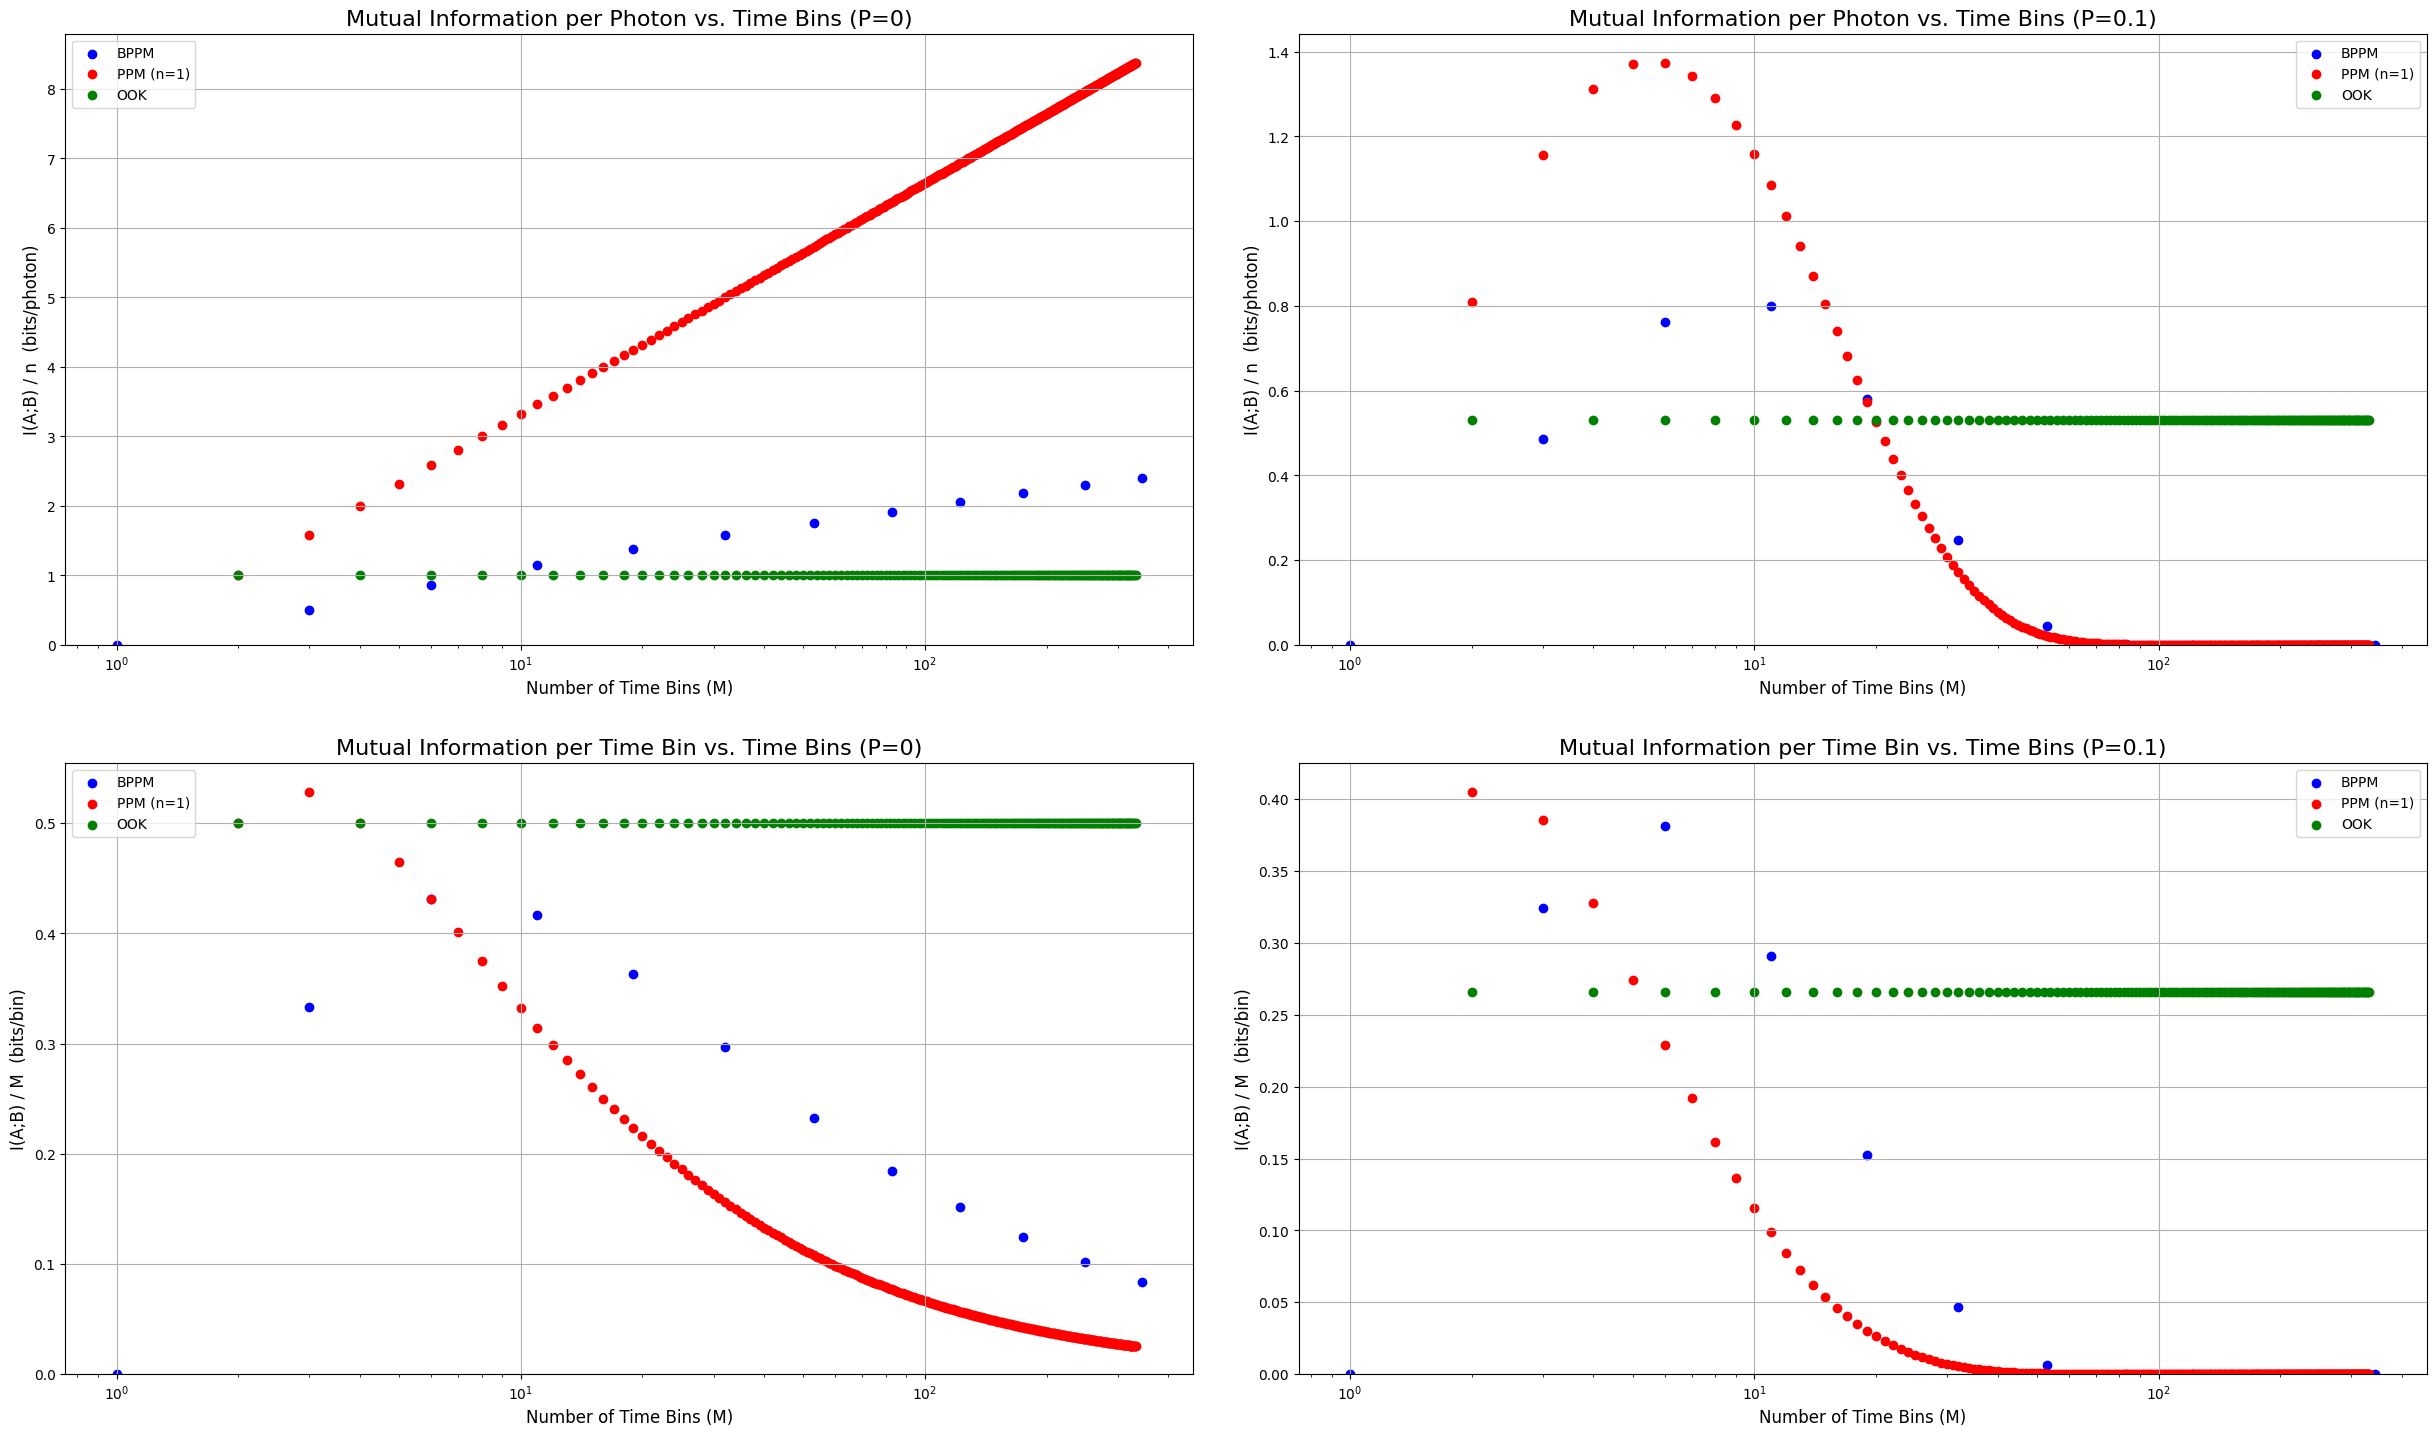

In [51]:
# In your main analysis notebook

import matplotlib.pyplot as plt
import numpy as np
import functions as fn # Your new library!

# --- Data Generation ---

# BPPM Data
TimeBin_BPPM_0, IperPhoton_BPPM_0, IperTimeBin_BPPM_0 = [], [], []
TimeBin_BPPM_1, IperPhoton_BPPM_1, IperTimeBin_BPPM_1 = [], [], []

for n in range(1, 13): # Loop for n=1 to 12
    # P = 0 case
    M0 = fn.compute_N_BPPM(n)
    PD0 = fn.P_D_BPPM(n, 0)
    I0 = fn.I_AB_BPPM(n, PD0)
    TimeBin_BPPM_0.append(M0)
    IperPhoton_BPPM_0.append(I0 / n)
    IperTimeBin_BPPM_0.append(I0 / M0)

    # P = 0.1 case
    M1 = fn.compute_N_BPPM(n)
    PD1 = fn.P_D_BPPM(n, 0.1)
    I1 = fn.I_AB_BPPM(n, PD1)
    TimeBin_BPPM_1.append(M1)
    IperPhoton_BPPM_1.append(I1 / n)
    IperTimeBin_BPPM_1.append(I1 / M1)

# PPM Data (n=1 photon)
TimeBin_PPM_0, IperPhoton_PPM_0, IperTimeBin_PPM_0 = [], [], []
TimeBin_PPM_1, IperPhoton_PPM_1, IperTimeBin_PPM_1 = [], [], []
n_ppm = 1

for M in range(2, 333): # M = number of time bins
    # P = 0 case
    PD0 = fn.P_D_PPM(n_ppm, M, 0)
    I0 = fn.I_AB_PPM(n_ppm, M, PD0)
    TimeBin_PPM_0.append(M)
    IperPhoton_PPM_0.append(I0 / n_ppm)
    IperTimeBin_PPM_0.append(I0 / M)
    
    # P = 0.1 case
    PD1 = fn.P_D_PPM(n_ppm, M, 0.1)
    I1 = fn.I_AB_PPM(n_ppm, M, PD1)
    TimeBin_PPM_1.append(M)
    IperPhoton_PPM_1.append(I1 / n_ppm)
    IperTimeBin_PPM_1.append(I1 / M)
    
# OOK Data
TimeBin_OOK_0, IperPhoton_OOK_0, IperTimeBin_OOK_0 = [], [], []
TimeBin_OOK_1, IperPhoton_OOK_1, IperTimeBin_OOK_1 = [], [], []

for n_ook in range(1, 167):
    M = 2 * n_ook # For OOK, M = 2n
    # P = 0 case
    I0 = fn.I_AB_OOK(n_ook, 0)
    TimeBin_OOK_0.append(M)
    IperPhoton_OOK_0.append(I0 / n_ook)
    IperTimeBin_OOK_0.append(I0 / M)

    # P = 0.1 case
    I1 = fn.I_AB_OOK(n_ook, 0.1)
    TimeBin_OOK_1.append(M)
    IperPhoton_OOK_1.append(I1 / n_ook)
    IperTimeBin_OOK_1.append(I1 / M)

# --- Plotting ---
figure, axis = plt.subplots(2,2,figsize=(25,15))
# (Your plotting code remains the same, just using the new data lists)

# Plot for P=0 per Photon
axis[0, 0].scatter(TimeBin_BPPM_0, IperPhoton_BPPM_0, label='BPPM', color='blue')
axis[0, 0].scatter(TimeBin_PPM_0, IperPhoton_PPM_0, label='PPM (n=1)', color='red')
axis[0, 0].scatter(TimeBin_OOK_0, IperPhoton_OOK_0, label='OOK', color='green')
axis[0, 0].set_title('Mutual Information per Photon vs. Time Bins (P=0)', fontsize=16)
axis[0, 0].set_xlabel('Number of Time Bins (M)', fontsize=12)
axis[0, 0].set_ylabel('I(A;B) / n  (bits/photon)', fontsize=12)
axis[0, 0].set_xscale('log')
axis[0, 0].set_ylim(bottom=0)
axis[0, 0].grid(True)
axis[0, 0].legend()

# Plot for P=0.1 per Photon
axis[0, 1].scatter(TimeBin_BPPM_1, IperPhoton_BPPM_1, label='BPPM', color='blue')
axis[0, 1].scatter(TimeBin_PPM_1, IperPhoton_PPM_1, label='PPM (n=1)', color='red')
axis[0, 1].scatter(TimeBin_OOK_1, IperPhoton_OOK_1, label='OOK', color='green')
axis[0, 1].set_title('Mutual Information per Photon vs. Time Bins (P=0.1)', fontsize=16)
axis[0, 1].set_xlabel('Number of Time Bins (M)', fontsize=12)
axis[0, 1].set_ylabel('I(A;B) / n  (bits/photon)', fontsize=12)
axis[0, 1].set_xscale('log')
axis[0, 1].set_ylim(bottom=0)
axis[0, 1].grid(True)
axis[0, 1].legend()

# Plot for P=0 per Time Bin
axis[1, 0].scatter(TimeBin_BPPM_0, IperTimeBin_BPPM_0, label='BPPM', color='blue')
axis[1, 0].scatter(TimeBin_PPM_0, IperTimeBin_PPM_0, label='PPM (n=1)', color='red')
axis[1, 0].scatter(TimeBin_OOK_0, IperTimeBin_OOK_0, label='OOK', color='green')
axis[1, 0].set_title('Mutual Information per Time Bin vs. Time Bins (P=0)', fontsize=16)
axis[1, 0].set_xlabel('Number of Time Bins (M)', fontsize=12)
axis[1, 0].set_ylabel('I(A;B) / M  (bits/bin)', fontsize=12)
axis[1, 0].set_xscale('log')
axis[1, 0].set_ylim(bottom=0)
axis[1, 0].grid(True)
axis[1, 0].legend()

# Plot for P=0.1 per Time Bin
axis[1, 1].scatter(TimeBin_BPPM_1, IperTimeBin_BPPM_1, label='BPPM', color='blue')
axis[1, 1].scatter(TimeBin_PPM_1, IperTimeBin_PPM_1, label='PPM (n=1)', color='red')
axis[1, 1].scatter(TimeBin_OOK_1, IperTimeBin_OOK_1, label='OOK', color='green')
axis[1, 1].set_title('Mutual Information per Time Bin vs. Time Bins (P=0.1)', fontsize=16)
axis[1, 1].set_xlabel('Number of Time Bins (M)', fontsize=12)
axis[1, 1].set_ylabel('I(A;B) / M  (bits/bin)', fontsize=12)
axis[1, 1].set_xscale('log')
axis[1, 1].set_ylim(bottom=0)
axis[1, 1].grid(True)
axis[1, 1].legend()

figure.tight_layout(pad=3.0)
figure.set_facecolor("white")
plt.show()

## Another way of writing OOK

In [52]:
# # def M_OOK(n_OOK):
# #     return 2*n_OOK 

# def compute_M_OOK(n_OOK):
#   M_OOK = n_OOK * 2
#   return M_OOK

# def K(M_OOK):
#     return 2**M_OOK

# def matrix_size(n_OOK):
#     return 2**n_OOK

# def P_XY(matrix_size):
#     matrix = np.zeros((matrix_size, matrix_size))
    
#     for i in range(matrix_size):
#         for j in range(matrix_size):
#             row_binary = bin(i)[2:].zfill(n_OOK)  # Binary representation of row index
#             col_binary = bin(j)[2:].zfill(n_OOK)  # Binary representation of column index


#             m = 1.0  # Default value for 'm'
#             for k in range(n_OOK):
#                 if row_binary[k] == '0' and col_binary[k] == '1':
#                     m *= o  # Update value to 'o'
#                 elif row_binary[k] == '1' and col_binary[k] == '0':
#                     m *= p  # Update value to 'p'
#                 elif row_binary[k] == '1' and col_binary[k] == '1':
#                     m *= q  # Update value to 'q'

#             matrix[i][j] = m
    
#     return np.array(matrix) 

# def P_XY_OOK(P_XY, K):
#     return P_XY * (1/K)

# def P_X(P_XY_OOK):
#     PX = np.sum(P_XY_OOK, axis=1)
#     return PX

# def P_Y(P_XY_OOK):
#     PY = np.sum(P_XY_OOK, axis=0)
#     return PY

# def P_Y_X(P_XY_OOK, PX): 
#     PYX = P_XY_OOK / PX [:, np.newaxis]  # Adjust dimensions for proper broadcasting division
#     return PYX

# def P_X_Y(P_XY_OOK, PY): 
#     PXY = P_XY_OOK / PY
#     return PXY

# def H_X(P_X):
#     HX = -np.sum(P_X * np.log2(P_X))
#     return HX

# def H_Y(P_Y):
#     HY = -np.sum(P_Y * np.log2(P_Y))
#     return HY

# def H_XY(P_XY_OOK):
#     HXY = -np.sum(P_XY_OOK * np.log2(P_XY_OOK + 1e-10))
#     return HXY

# def H_X_Y(P_XY_OOK, P_X_Y):
#     HXY = -np.sum(P_XY_OOK * np.log2(P_X_Y + 1e-10), axis=0).sum()
#     return HXY

# def H_Y_X(P_XY_OOK, P_Y_X): 
#     HYX = -np.sum(P_XY_OOK * np.log2(P_Y_X + 1e-10), axis=0).sum()
#     return HYX 

# def M_I(H_X, H_X_Y):
#     MI = H_X - H_X_Y
#     return MI

# def M_I_per_Photon(M_I,n_OOK):
#     MIperPhoton = M_I / (n_OOK/2)
#     return MIperPhoton

## Mutual Information per Photon

### P = 0

In [53]:
# Create empty lists to store the results
IperPhoton_AB_BPPM_list_0 = []
IperTimeBin_AB_BPPM_list_0 = []
IperPhoton_AB_BPPM_list_0_1 = []
IperTimeBin_AB_BPPM_list_0_1 = []

TimeBin_BPPM_list_0 = []
TimeBin_BPPM_list_0_1 = []

# --- Loop for P=0 ---
for n in range(1, 6):
    P = 0
    # FIX: Call the function from your library with the new name
    M = fn.compute_N_BPPM(n)
    TimeBin_BPPM_list_0.append(M)
    
    # FIX: Use the simplified P_D and I_AB functions from the library
    P_D_val = fn.P_D_BPPM(n, P)
    I_AB_val = fn.I_AB_BPPM(n, P_D_val)

    IperPhoton_AB_BPPM_list_0.append(I_AB_val / n)
    IperTimeBin_AB_BPPM_list_0.append(I_AB_val / M)

# --- Loop for P=0.1 ---
for n in range(1, 6):
    P = 0.1
    # FIX: Call the function from your library with the new name
    M = fn.compute_N_BPPM(n)
    TimeBin_BPPM_list_0_1.append(M)

    # FIX: Use the simplified P_D and I_AB functions from the library
    P_D_val = fn.P_D_BPPM(n, P)
    I_AB_val = fn.I_AB_BPPM(n, P_D_val)

    IperPhoton_AB_BPPM_list_0_1.append(I_AB_val / n)
    IperTimeBin_AB_BPPM_list_0_1.append(I_AB_val / M)
    
print("BPPM Data Calculation Complete.")

BPPM Data Calculation Complete.


In [54]:
# Create empty lists to store the results
IperPhoton_AB_PPM_list_0 = []
IperTimeBin_AB_PPM_list_0 = []
IperPhoton_AB_PPM_list_0_1 = []
IperTimeBin_AB_PPM_list_0_1 = []

TimeBin_PPM_list_0 = []
TimeBin_PPM_list_0_1 = []

n_PPM = 1 # For standard PPM, we always use 1 photon

# --- Loop for P=0 ---
# Note: The original loop was range(1, 27). For PPM with 1 photon, M must be >= 1.
# But M=1 gives log2(1)=0, so we start the loop from M=2.
for M_PPM in range(2, 28):
    P = 0
    TimeBin_PPM_list_0.append(M_PPM)
    
    # FIX: Use the simplified P_D and I_AB functions from the library
    P_D_val = fn.P_D_PPM(n_PPM, M_PPM, P)
    I_AB_val = fn.I_AB_PPM(n_PPM, M_PPM, P_D_val)

    IperPhoton_AB_PPM_list_0.append(I_AB_val / n_PPM)
    IperTimeBin_AB_PPM_list_0.append(I_AB_val / M_PPM)

# --- Loop for P=0.1 ---
for M_PPM in range(2, 28):
    P = 0.1
    TimeBin_PPM_list_0_1.append(M_PPM)
    
    # FIX: Use the simplified P_D and I_AB functions from the library
    P_D_val = fn.P_D_PPM(n_PPM, M_PPM, P)
    I_AB_val = fn.I_AB_PPM(n_PPM, M_PPM, P_D_val)

    IperPhoton_AB_PPM_list_0_1.append(I_AB_val / n_PPM)
    IperTimeBin_AB_PPM_list_0_1.append(I_AB_val / M_PPM)

print("PPM Data Calculation Complete.")

PPM Data Calculation Complete.


In [55]:
# A cleaner way to inspect the data after the loop
print("Last Time Bin value for BPPM (P=0.1):", TimeBin_BPPM_list_0_1[-1])
print("Full list of Time Bins for BPPM (P=0.1):", TimeBin_BPPM_list_0_1)

print("\nLast Time Bin value for PPM (P=0.1):", TimeBin_PPM_list_0_1[-1])
print("Full list of Time Bins for PPM (P=0.1):", TimeBin_PPM_list_0_1)

Last Time Bin value for BPPM (P=0.1): 19
Full list of Time Bins for BPPM (P=0.1): [1, 3, 6, 11, 19]

Last Time Bin value for PPM (P=0.1): 27
Full list of Time Bins for PPM (P=0.1): [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]


In [56]:
I_AB_OOK_list_0 = []
IperPhoton_AB_OOK_list_0 = []
TimeBin_OOK_list_0 = []
IperTimeBin_AB_OOK_list_0 = []
IperPhotonTimeBin_AB_OOK_list_0 = []

I_AB_OOK_list_0_1 = []
IperPhoton_AB_OOK_list_0_1 = []
TimeBin_OOK_list_0_1 = []
IperTimeBin_AB_OOK_list_0_1 = []
IperPhotonTimeBin_AB_OOK_list_0_1 = []

for n_OOK in range(1, 14):
    m = 1
    o = 0
    p = 0
    q = 1 - p
    M_OOK = compute_M_OOK(n_OOK)
    K_val = K(n_OOK)
    matrix_size_val = matrix_size(n_OOK)
    P_XY_val = P_XY(matrix_size_val)
    P_XY_OOK_val = P_XY_OOK(P_XY_val, K_val)
    P_X_val = P_X(P_XY_OOK_val)
    P_Y_val = P_Y(P_XY_OOK_val)
    P_X_Y_val = P_X_Y(P_XY_OOK_val, P_Y_val)
    H_X_val = H_X(P_X_val)
    H_X_Y_val = H_X_Y(P_XY_OOK_val, P_X_Y_val)
    I_val = M_I(H_X_val, H_X_Y_val)
    
    IperPhoton_AB_OOK_val = M_I_per_Photon(I_val,n_OOK)
    TimeBin_OOK_list_0.append(M_OOK) 
    
    I_AB_OOK_list_0_1.append(I_val)
    IperPhoton_AB_OOK_list_0.append(IperPhoton_AB_OOK_val)

    IperTimeBin_AB_OOK_val = I_val / M_OOK
    IperTimeBin_AB_OOK_list_0.append(IperTimeBin_AB_OOK_val)

    IperPhotonTimeBin_AB_OOK_val = I_val / (n_OOK * M_OOK)
    IperPhotonTimeBin_AB_OOK_list_0.append(IperPhotonTimeBin_AB_OOK_val) 

for n_OOK in range(1, 14):
    m = 1
    o = 0
    p = 0.1
    q = 1 - p
    M_OOK = compute_M_OOK(n_OOK)
    K_val = K(n_OOK)
    matrix_size_val = matrix_size(n_OOK)
    P_XY_val = P_XY(matrix_size_val)
    P_XY_OOK_val = P_XY_OOK(P_XY_val, K_val)
    P_X_val = P_X(P_XY_OOK_val)
    P_Y_val = P_Y(P_XY_OOK_val)
    P_X_Y_val = P_X_Y(P_XY_OOK_val, P_Y_val)
    H_X_val = H_X(P_X_val)
    H_X_Y_val = H_X_Y(P_XY_OOK_val, P_X_Y_val)
    I_val = M_I(H_X_val, H_X_Y_val)
    
    IperPhoton_AB_OOK_val = M_I_per_Photon(I_val,n_OOK)
    TimeBin_OOK_list_0_1.append(M_OOK) 
    
    I_AB_OOK_list_0_1.append(I_val)
    IperPhoton_AB_OOK_list_0_1.append(IperPhoton_AB_OOK_val)

    IperTimeBin_AB_OOK_val = I_val / M_OOK
    IperTimeBin_AB_OOK_list_0_1.append(IperTimeBin_AB_OOK_val)

    IperPhotonTimeBin_AB_OOK_val = I_val / (n_OOK * M_OOK)
    IperPhotonTimeBin_AB_OOK_list_0_1.append(IperPhotonTimeBin_AB_OOK_val)


KeyboardInterrupt: 

In [ ]:
IperTimeBin_AB_OOK_list_0

NameError: name 'IperTimeBin_AB_OOK_list_0' is not defined

In [ ]:
IperTimeBin_AB_OOK_list_0_1

[0.3791383287083927,
 0.3791383286832357,
 0.37913832868612407,
 0.37913832870067443,
 0.3791383287256561,
 0.37913832876330217,
 0.3791383288180806,
 0.3791383288969866,
 0.37913832901045835,
 0.37913832917386614,
 0.3791383294097122,
 0.3791383297507685,
 0.37913833024443977]

In [ ]:
# I_AB_OOK_list_0 = []
# I_AB_OOK_list_0_1 = []

# IperPhoton_AB_OOK_list_0 = []
# IperTimeBin_AB_OOK_list_0 = []
# IperPhotonTimeBin_AB_OOK_list_0 = []

# IperPhoton_AB_OOK_list_0_1 = []
# IperTimeBin_AB_OOK_list_0_1 = []
# IperPhotonTimeBin_AB_OOK_list_0_1 = []

# TimeBin_OOK_list_0 = []
# TimeBin_OOK_list_0_1 = []

# for n_OOK in range(3,167):
#     P = 0
#     M_OOK = compute_M_OOK(n_OOK)
#     TimeBin_OOK_list_0.append(M_OOK)
#     P_D_OOK_val = P_D_OOK(n_OOK, M_OOK, P, 0, 0, 0)
#     P_AB_OOK_val = P_AB_OOK_diagonal(n_OOK, P_D_OOK_val)
#     H_AB_OOK_val = H_AB_OOK_diagonal(P_AB_OOK_val, n_OOK)
#     I_AB_OOK_val = I_AB_OOK_diagonal(P_AB_OOK_val, n_OOK, P_D_OOK_val)
#     I_AB_OOK_list_0.append(I_AB_OOK_val)

#     IperPhoton_AB_OOK_val = I_AB_OOK_diagonal(P_AB_OOK_val, n_OOK, P_D_OOK_val) / n_OOK
#     IperPhoton_AB_OOK_list_0.append(IperPhoton_AB_OOK_val)

#     IperTimeBin_AB_OOK_val = I_AB_OOK_diagonal(P_AB_OOK_val, n_OOK, P_D_OOK_val) / M_OOK
#     IperTimeBin_AB_OOK_list_0.append(IperTimeBin_AB_OOK_val)

#     IperPhotonTimeBin_AB_OOK_val = I_AB_OOK_diagonal(P_AB_OOK_val, n_OOK, P_D_OOK_val)/ (n_OOK * M_OOK)
#     IperPhotonTimeBin_AB_OOK_list_0.append(IperPhotonTimeBin_AB_OOK_val)

# for n_OOK in range(3, 167):
#     P = 0.1
#     M_OOK = compute_M_OOK(n_OOK)
#     TimeBin_OOK_list_0_1.append(M_OOK)
#     P_D_OOK_val = P_D_OOK(n_OOK, M_OOK, P, 0, 0, 0)
#     P_AB_OOK_val = P_AB_OOK_diagonal(n_OOK, P_D_OOK_val)
#     H_AB_OOK_val = H_AB_OOK_diagonal(P_AB_OOK_val, n_OOK)
#     I_AB_OOK_val = I_AB_OOK_diagonal(P_AB_OOK_val, n_OOK, P_D_OOK_val)
#     I_AB_OOK_list_0_1.append(I_AB_OOK_val)

#     IperPhoton_AB_OOK_val = I_AB_OOK_diagonal(P_AB_OOK_val, n_OOK, P_D_OOK_val) / n_OOK
#     IperPhoton_AB_OOK_list_0_1.append(IperPhoton_AB_OOK_val)

#     IperTimeBin_AB_OOK_val = I_AB_OOK_diagonal(P_AB_OOK_val, n_OOK, P_D_OOK_val) / M_OOK
#     IperTimeBin_AB_OOK_list_0_1.append(IperTimeBin_AB_OOK_val)

#     IperPhotonTimeBin_AB_OOK_val = I_AB_OOK_diagonal(P_AB_OOK_val, n_OOK, P_D_OOK_val)/ (n_OOK * M_OOK)
#     IperPhotonTimeBin_AB_OOK_list_0_1.append(IperPhotonTimeBin_AB_OOK_val)

In [ ]:
# print(TimeBin_OOK_list_0), print(TimeBin_OOK_list_0[-1])

In [ ]:
# print(TimeBin_OOK_list_0_1), print(TimeBin_OOK_list_0[-1])

### Plot on Mutual Information per Photon Vs Time Bin

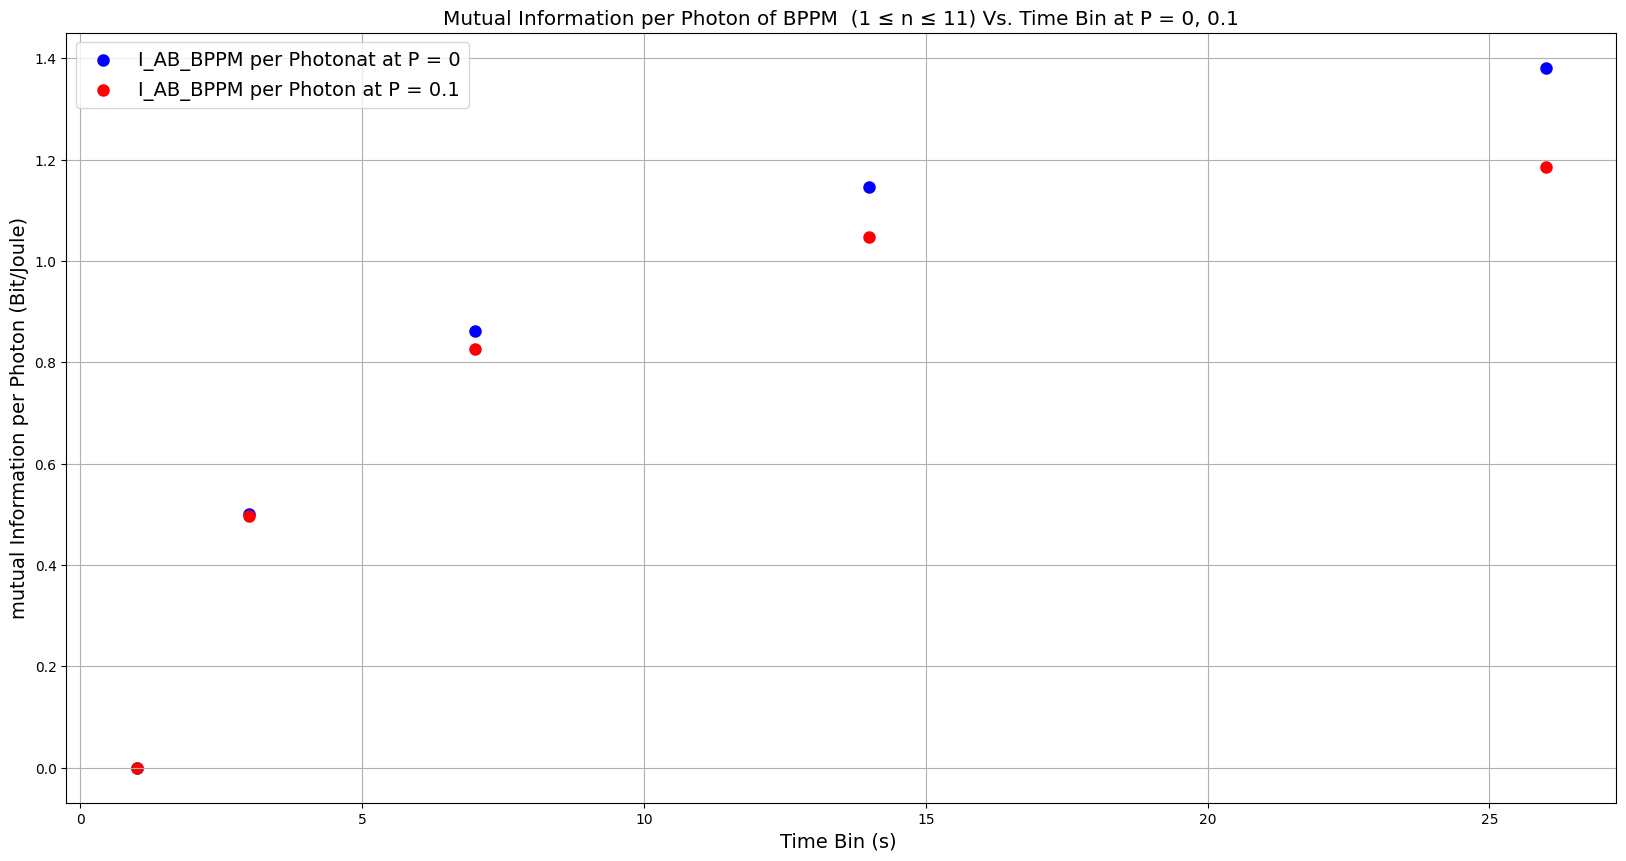

In [ ]:
figure, axis = plt.subplots(1,1,figsize=(20,10))

plt.scatter(TimeBin_BPPM_list_0, IperPhoton_AB_BPPM_list_0, label='I_AB_BPPM per Photonat at P = 0', color ='blue', linewidth=3, alpha=1)
plt.scatter(TimeBin_BPPM_list_0_1, IperPhoton_AB_BPPM_list_0_1, label='I_AB_BPPM per Photon at P = 0.1', color ='red', linewidth=3, alpha=1)
plt.title('Mutual Information per Photon of BPPM  (1 \u2264 n \u2264 11) Vs. Time Bin at P = 0, 0.1', fontsize='x-large')
plt.xlabel('Time Bin (s) ', fontsize = 14)
plt.ylabel('mutual Information per Photon (Bit/Joule)', fontsize = 14)
plt.grid(True)
plt.legend(fontsize=14)

# for index in range(len(TimeBin_BPPM_list_0)):
#   plt.text(TimeBin_BPPM_list_0[index], IperPhoton_AB_BPPM_list_0[index], round(IperPhoton_AB_BPPM_list_0[index],1), size=12)

# for index in range(len(TimeBin_BPPM_list_0_1)):
#   plt.text(TimeBin_BPPM_list_0_1[index], IperPhoton_AB_BPPM_list_0_1[index], round(IperPhoton_AB_BPPM_list_0_1[index],1), size=12)

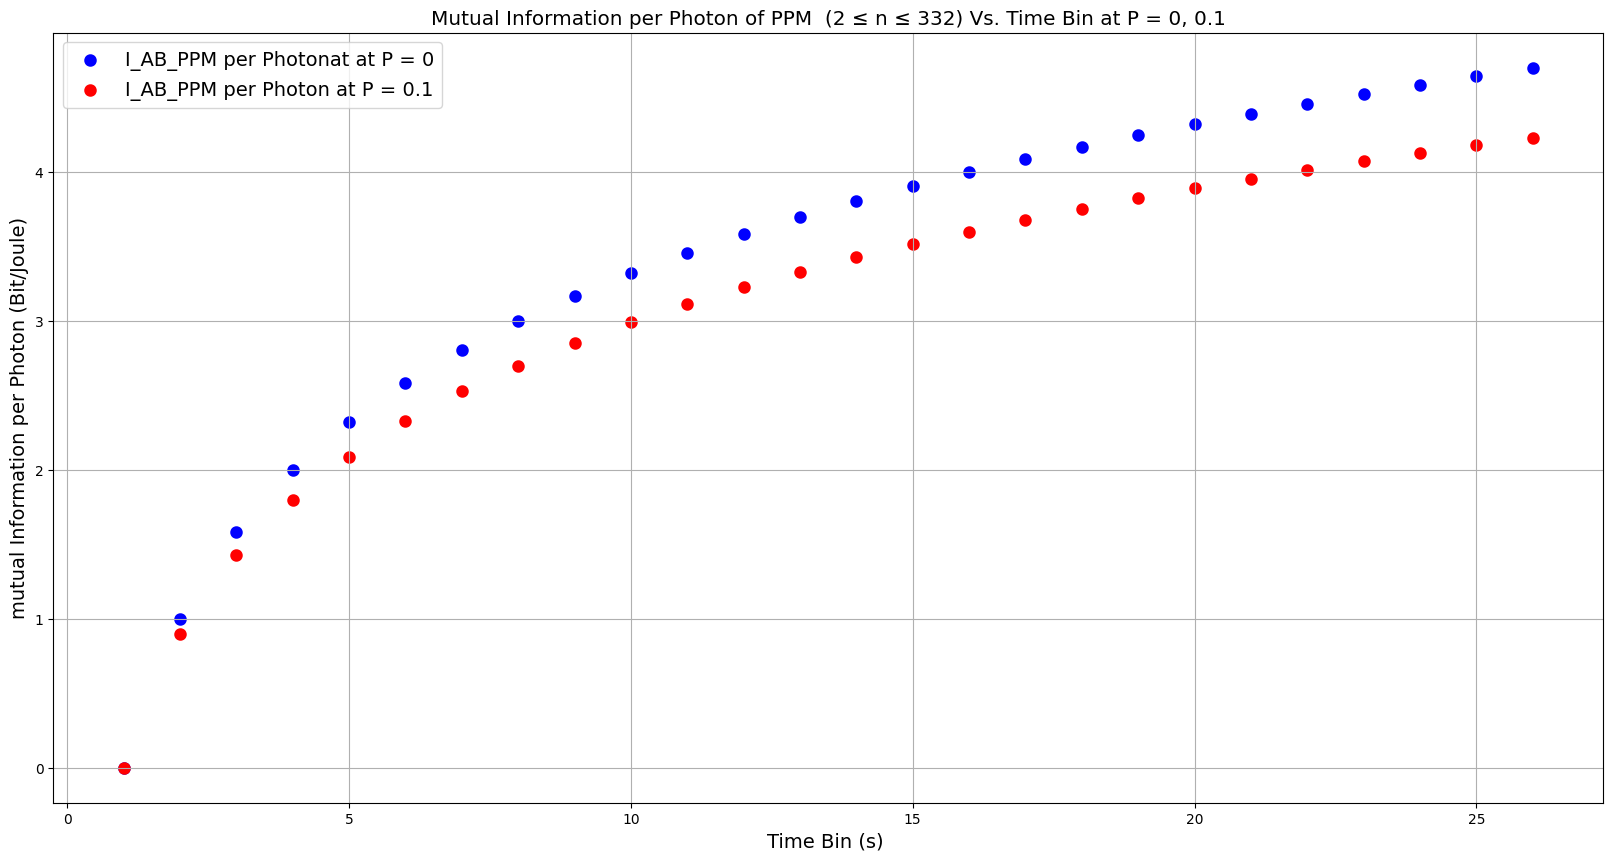

In [ ]:
figure, axis = plt.subplots(1,1,figsize=(20,10))

plt.scatter(TimeBin_PPM_list_0, IperPhoton_AB_PPM_list_0, label='I_AB_PPM per Photonat at P = 0', color ='blue', linewidth=3, alpha=1)
plt.scatter(TimeBin_PPM_list_0_1, IperPhoton_AB_PPM_list_0_1, label='I_AB_PPM per Photon at P = 0.1', color ='red', linewidth=3, alpha=1)
plt.title('Mutual Information per Photon of PPM  (2 \u2264 n \u2264 332) Vs. Time Bin at P = 0, 0.1', fontsize='x-large')
plt.xlabel('Time Bin (s) ', fontsize = 14)
plt.ylabel('mutual Information per Photon (Bit/Joule)', fontsize = 14)
plt.grid(True)
plt.legend(fontsize=14)

# for index in range(0,21):
#   plt.text(TimeBin_PPM_list_0[index], IperPhoton_AB_PPM_list_0[index], round(IperPhoton_AB_PPM_list_0[index],1), size=12)

# for index in range(0,21):
#   plt.text(TimeBin_PPM_list_0_1[index], IperPhoton_AB_PPM_list_0_1[index], round(IperPhoton_AB_PPM_list_0_1[index],1), size=12)

In [ ]:
TimeBin_OOK_list_0_1

[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26]

In [ ]:
IperPhoton_AB_OOK_list_0_1

[1.5165533148335708,
 1.5165533147329429,
 1.5165533147444963,
 1.5165533148026977,
 1.5165533149026245,
 1.5165533150532087,
 1.5165533152723225,
 1.5165533155879465,
 1.5165533160418334,
 1.5165533166954646,
 1.5165533176388488,
 1.516553319003074,
 1.516553320977759]

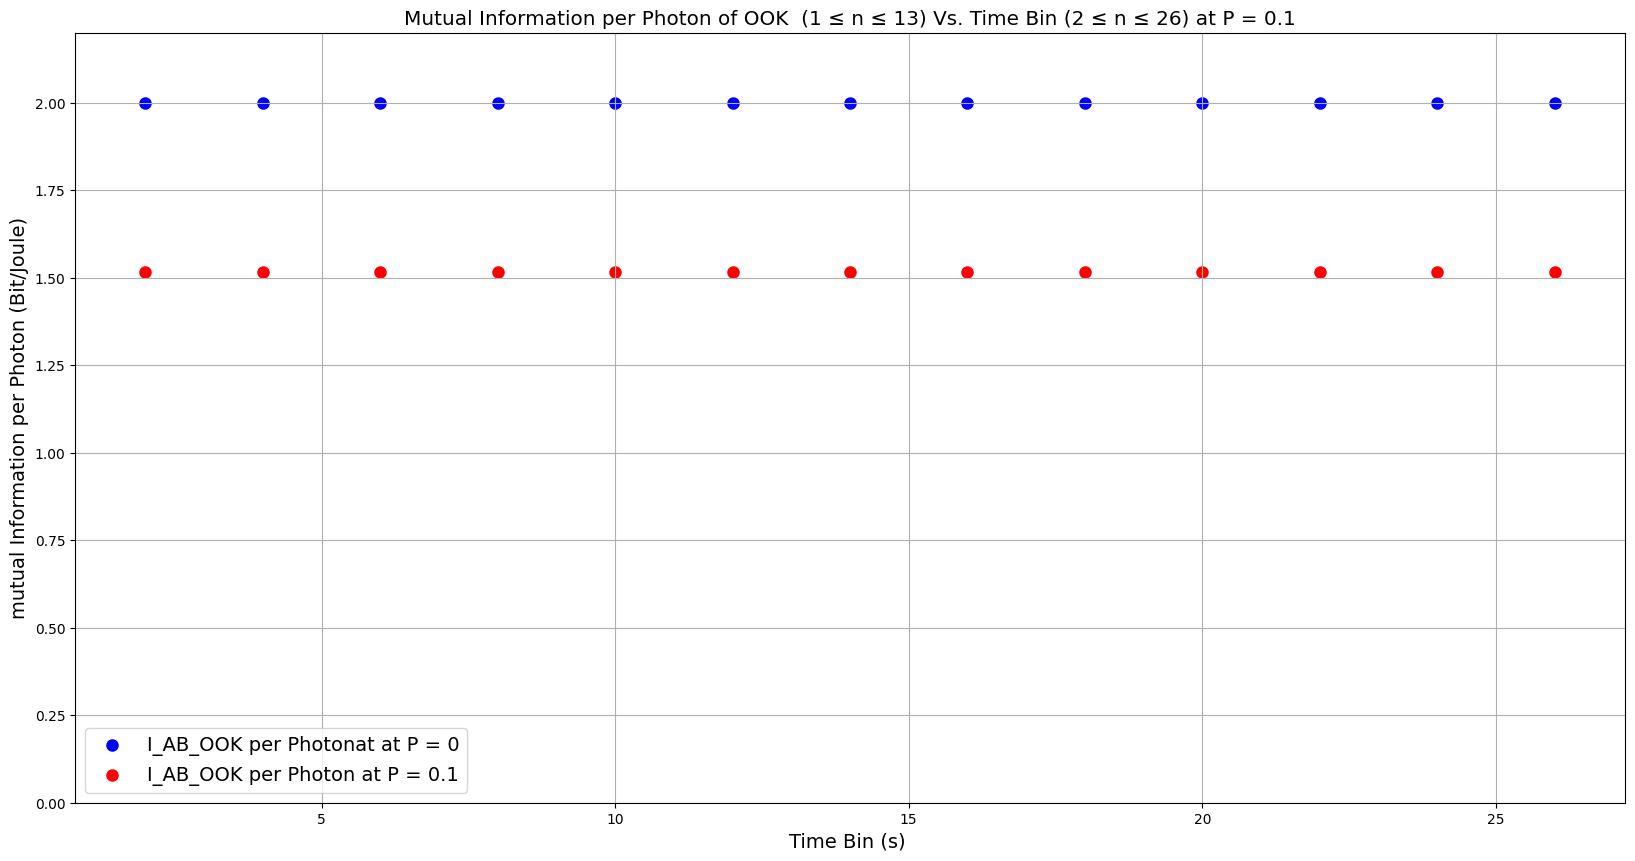

In [ ]:
figure, axis = plt.subplots(1,1,figsize=(20,10))

plt.scatter(TimeBin_OOK_list_0, IperPhoton_AB_OOK_list_0, label='I_AB_OOK per Photonat at P = 0', color ='blue', linewidth=3, alpha=1)
plt.scatter(TimeBin_OOK_list_0_1, IperPhoton_AB_OOK_list_0_1, label='I_AB_OOK per Photon at P = 0.1', color ='red', linewidth=3, alpha=1)
plt.title('Mutual Information per Photon of OOK  (1 \u2264 n \u2264 13) Vs. Time Bin (2 \u2264 n \u2264 26) at P = 0.1', fontsize='x-large')
plt.xlabel('Time Bin (s) ', fontsize = 14)
plt.ylabel('mutual Information per Photon (Bit/Joule)', fontsize = 14)
plt.ylim(0, 2.2) 
plt.grid(True)
plt.legend(fontsize=14)

# for index in range(0,21): # len(TimeBin_OOK_list_0)
#   plt.text(TimeBin_OOK_list_0[index], IperPhoton_AB_OOK_list_0[index], round(IperPhoton_AB_OOK_list_0[index],2), size=12)

# for index in range(0,11): # (len(TimeBin_OOK_list_0_1)
#   plt.text(TimeBin_OOK_list_0_1[index], IperPhoton_AB_OOK_list_0_1[index], round(IperPhoton_AB_OOK_list_0_1[index],2), size=12)

### Plot on Mutual Information per Time Bin Vs Time Bin

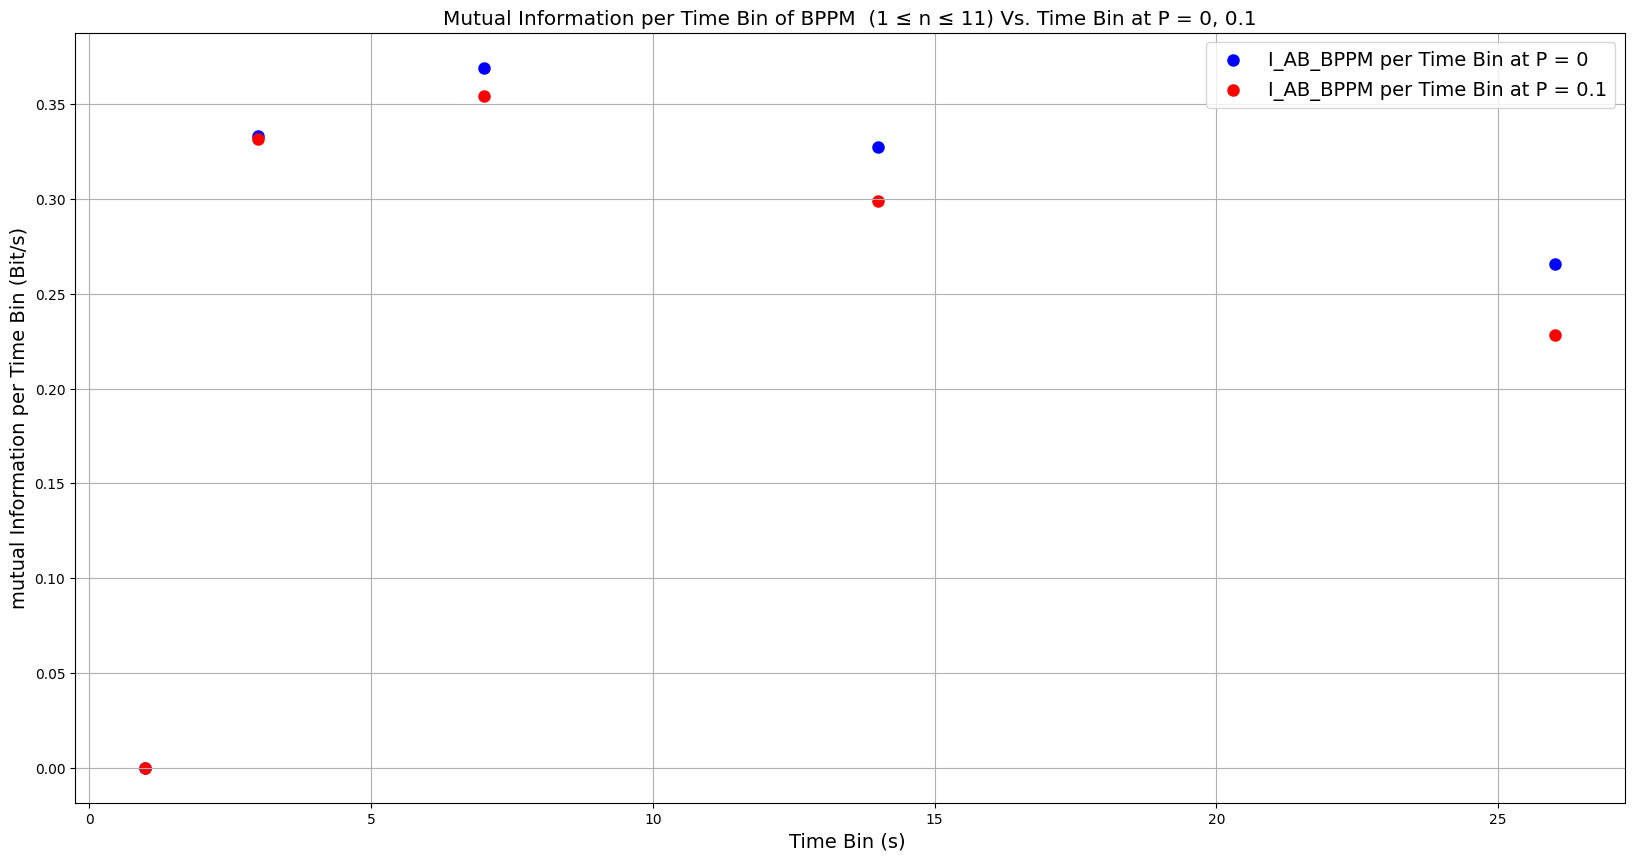

In [ ]:
figure, axis = plt.subplots(1,1,figsize=(20,10))

plt.scatter(TimeBin_BPPM_list_0, IperTimeBin_AB_BPPM_list_0, label='I_AB_BPPM per Time Bin at P = 0', color ='blue', linewidth=3, alpha=1)
plt.scatter(TimeBin_BPPM_list_0_1, IperTimeBin_AB_BPPM_list_0_1, label='I_AB_BPPM per Time Bin at P = 0.1', color ='red', linewidth=3, alpha=1)
# plt.plot(P_list, I_AB_General_n2_list_5, label='I_AB_General for 2 Photons', color ='green', linewidth=3, alpha=1)
# plt.plot(P_list, I_AB_General_n3_list_5, label='I_AB_General for 3 Photons',color ='orange', linewidth=3, alpha=1)
plt.title('Mutual Information per Time Bin of BPPM  (1 \u2264 n \u2264 11) Vs. Time Bin at P = 0, 0.1', fontsize='x-large')
plt.xlabel('Time Bin (s) ', fontsize = 14)
plt.ylabel('mutual Information per Time Bin (Bit/s)', fontsize = 14)
plt.grid(True)
plt.legend(fontsize=14)

# for index in range(len(TimeBin_BPPM_list_0)):
#   plt.text(TimeBin_BPPM_list_0[index], IperTimeBin_AB_BPPM_list_0[index], round(IperTimeBin_AB_BPPM_list_0[index],1), size=12)

# for index in range(len(TimeBin_BPPM_list_0_1)):
#   plt.text(TimeBin_BPPM_list_0_1[index], IperTimeBin_AB_BPPM_list_0_1[index], round(IperTimeBin_AB_BPPM_list_0_1[index],1), size=12)

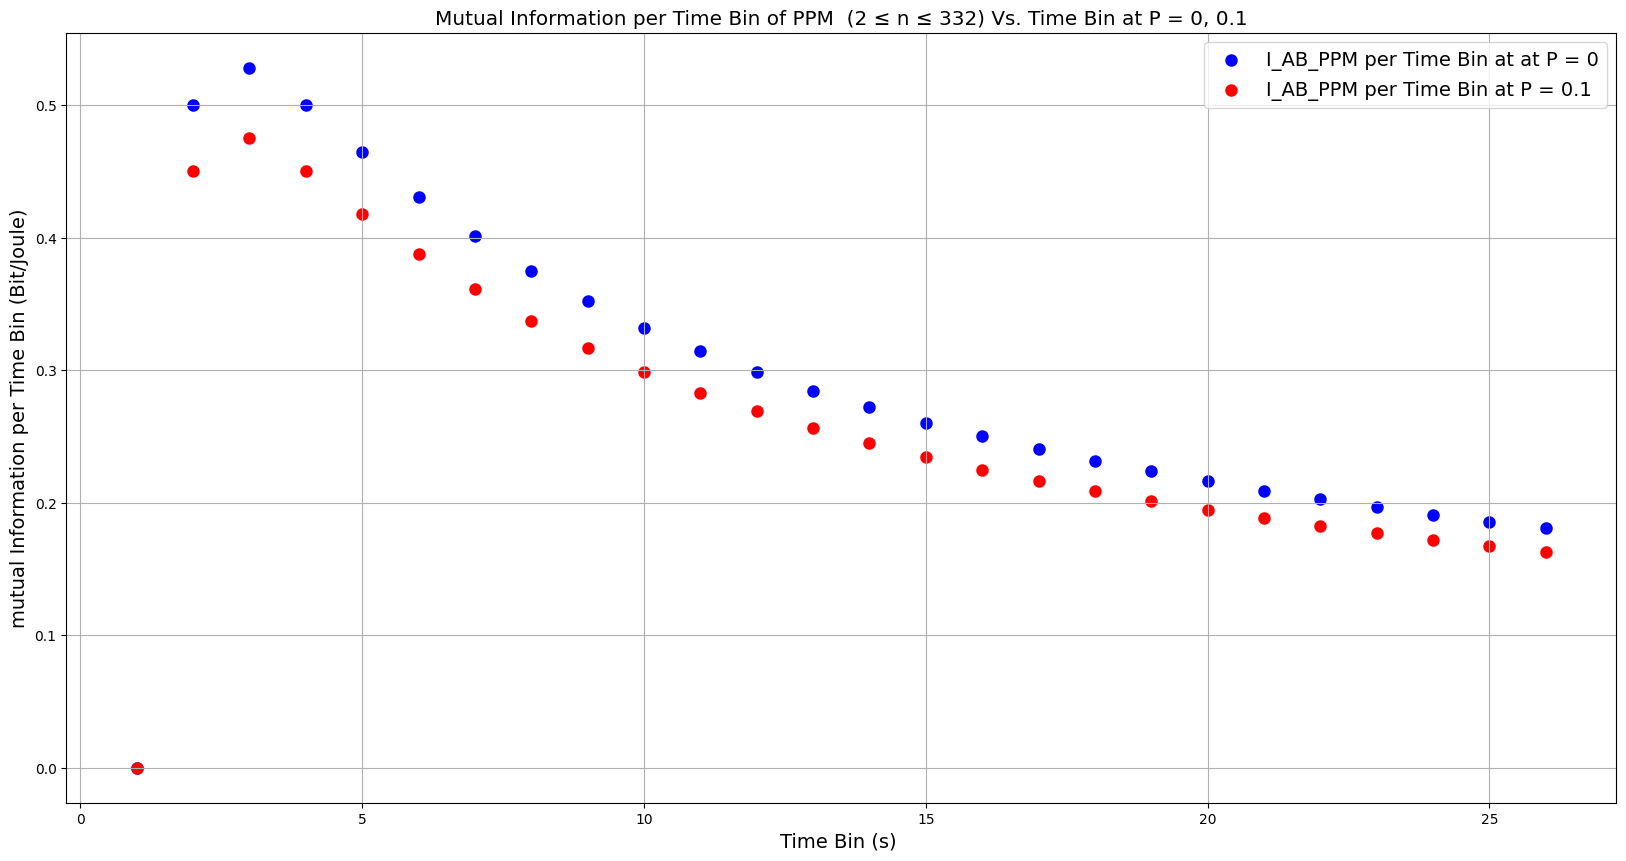

In [ ]:
figure, axis = plt.subplots(1,1,figsize=(20,10))

plt.scatter(TimeBin_PPM_list_0, IperTimeBin_AB_PPM_list_0, label='I_AB_PPM per Time Bin at at P = 0', color ='blue', linewidth=3, alpha=1)
plt.scatter(TimeBin_PPM_list_0_1, IperTimeBin_AB_PPM_list_0_1, label='I_AB_PPM per Time Bin at P = 0.1', color ='red', linewidth=3, alpha=1)
plt.title('Mutual Information per Time Bin of PPM  (2 \u2264 n \u2264 332) Vs. Time Bin at P = 0, 0.1', fontsize='x-large')
plt.xlabel('Time Bin (s) ', fontsize = 14)
plt.ylabel('mutual Information per Time Bin (Bit/Joule)', fontsize = 14)
plt.grid(True)
plt.legend(fontsize=14)

# for index in range(0,21):
#   plt.text(TimeBin_PPM_list_0[index], IperTimeBin_AB_PPM_list_0[index], round(IperTimeBin_AB_PPM_list_0[index],1), size=12)

# for index in range(0,21):
#   plt.text(TimeBin_PPM_list_0_1[index], IperTimeBin_AB_PPM_list_0_1[index], round(IperTimeBin_AB_PPM_list_0_1[index],1), size=12)

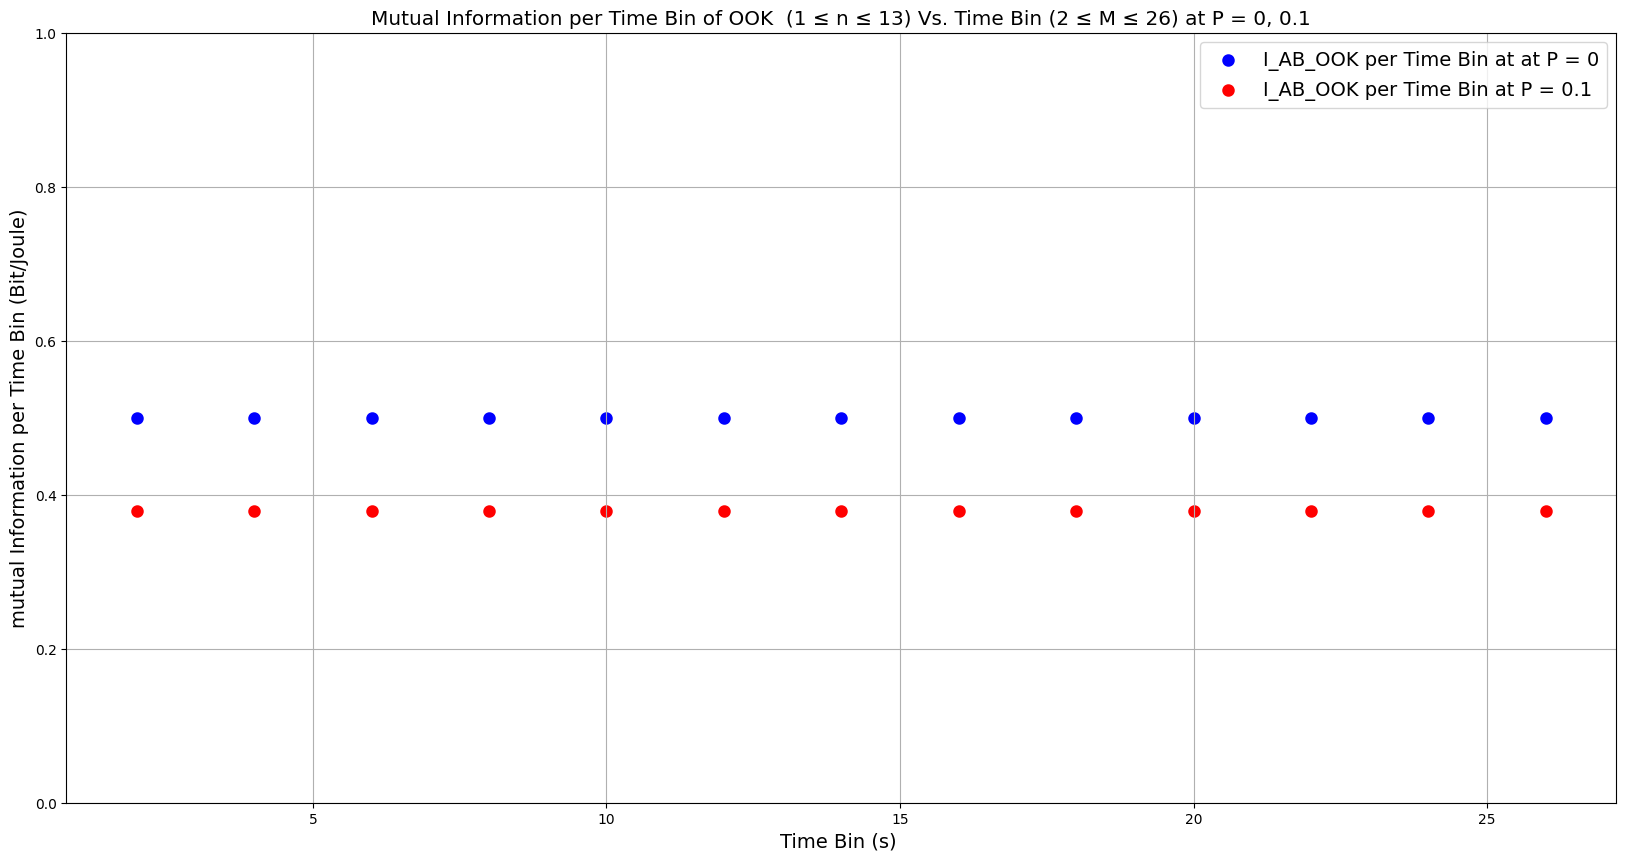

In [ ]:
figure, axis = plt.subplots(1,1,figsize=(20,10))

plt.scatter(TimeBin_OOK_list_0, IperTimeBin_AB_OOK_list_0, label='I_AB_OOK per Time Bin at at P = 0', color ='blue', linewidth=3, alpha=1)
plt.scatter(TimeBin_OOK_list_0_1, IperTimeBin_AB_OOK_list_0_1, label='I_AB_OOK per Time Bin at P = 0.1', color ='red', linewidth=3, alpha=1)
# plt.plot(P_list, I_AB_General_n2_list_5, label='I_AB_General for 2 Photons', color ='green', linewidth=3, alpha=1)
# plt.plot(P_list, I_AB_General_n3_list_5, label='I_AB_General for 3 Photons',color ='orange', linewidth=3, alpha=1)
plt.title('Mutual Information per Time Bin of OOK  (1 \u2264 n \u2264 13) Vs. Time Bin (2 \u2264 M \u2264 26) at P = 0, 0.1', fontsize='x-large')
plt.xlabel('Time Bin (s) ', fontsize = 14)
plt.ylabel('mutual Information per Time Bin (Bit/Joule)', fontsize = 14)
plt.ylim(0, 1.0)
plt.grid(True)
plt.legend(fontsize=14)

# for index in range(0,21):
#   plt.text(TimeBin_OOK_list_0[index], IperTimeBin_AB_OOK_list_0[index], round(IperTimeBin_AB_OOK_list_0[index],1), size=12)

# for index in range(0,21):
#   plt.text(TimeBin_OOK_list_0_1[index], IperTimeBin_AB_OOK_list_0_1[index], round(IperTimeBin_AB_OOK_list_0_1[index],1), size=12)

In [ ]:
TimeBin_OOK_list_0_1

[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26]

## Combined Plot

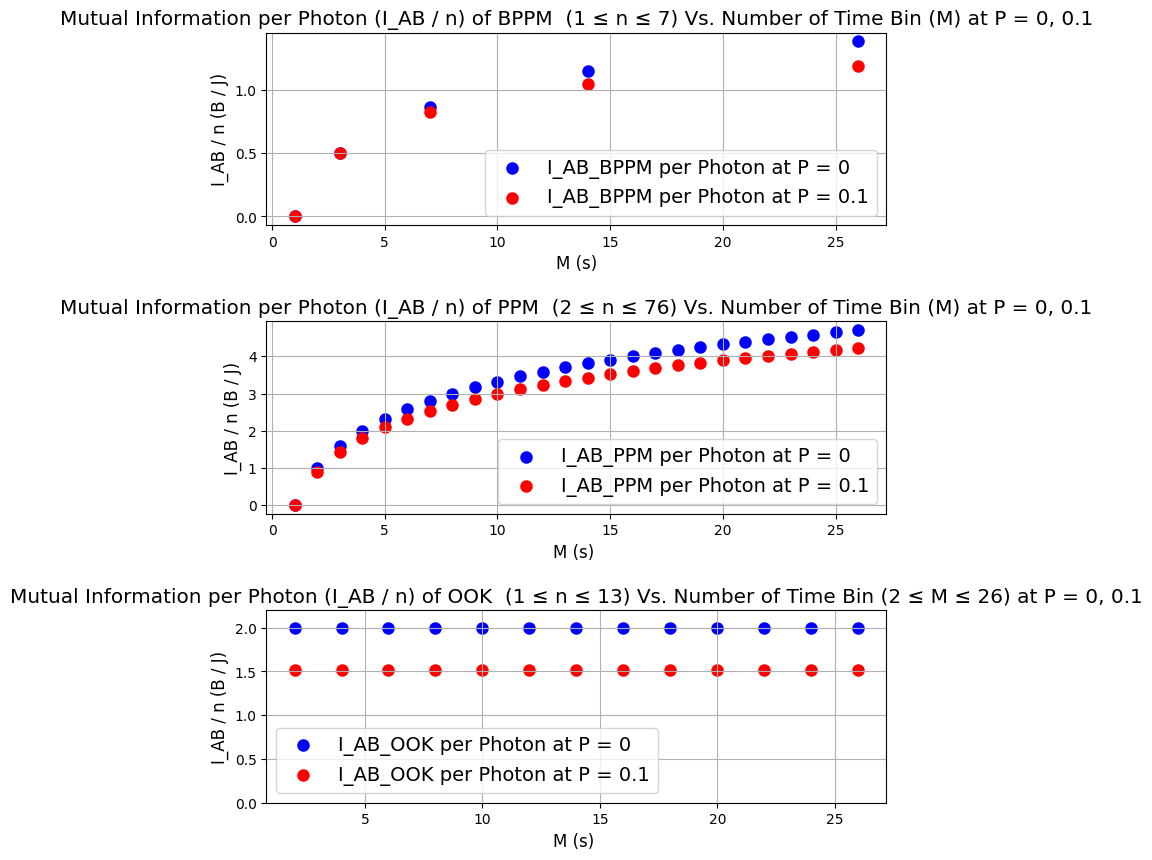

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8, 10))

axs[0].scatter(TimeBin_BPPM_list_0, IperPhoton_AB_BPPM_list_0, label='I_AB_BPPM per Photon at P = 0', color ='blue', linewidth=3, alpha=1)
axs[0].scatter(TimeBin_BPPM_list_0_1, IperPhoton_AB_BPPM_list_0_1, label='I_AB_BPPM per Photon at P = 0.1', color ='red', linewidth=3, alpha=1)
axs[0].set_title('Mutual Information per Photon (I_AB / n) of BPPM  (1 \u2264 n \u2264 7) Vs. Number of Time Bin (M) at P = 0, 0.1', fontsize='x-large')
axs[0].set_xlabel('M (s)', fontsize = 12)
axs[0].set_ylabel('I_AB / n (B / J)', fontsize = 12)
axs[0].grid(True)
axs[0].legend(fontsize=14)

  
axs[1].scatter(TimeBin_PPM_list_0, IperPhoton_AB_PPM_list_0, label='I_AB_PPM per Photon at P = 0', color ='blue', linewidth=3, alpha=1)
axs[1].scatter(TimeBin_PPM_list_0_1, IperPhoton_AB_PPM_list_0_1, label='I_AB_PPM per Photon at P = 0.1', color ='red', linewidth=3, alpha=1)
axs[1].set_title('Mutual Information per Photon (I_AB / n) of PPM  (2 \u2264 n \u2264 76) Vs. Number of Time Bin (M) at P = 0, 0.1', fontsize='x-large')
axs[1].set_xlabel('M (s) ', fontsize = 12)
axs[1].set_ylabel('I_AB / n (B / J)', fontsize = 12)
axs[1].grid(True)
axs[1].legend(fontsize=14)

axs[2].scatter(TimeBin_OOK_list_0, IperPhoton_AB_OOK_list_0, label='I_AB_OOK per Photon at P = 0', color ='blue', linewidth=3, alpha=1)
axs[2].scatter(TimeBin_OOK_list_0_1, IperPhoton_AB_OOK_list_0_1, label='I_AB_OOK per Photon at P = 0.1', color ='red', linewidth=3, alpha=1)
axs[2].set_title('Mutual Information per Photon (I_AB / n) of OOK  (1 \u2264 n \u2264 13) Vs. Number of Time Bin (2 \u2264 M \u2264 26) at P = 0, 0.1', fontsize='x-large')
axs[2].set_xlabel('M (s) ', fontsize = 12)
axs[2].set_ylabel('I_AB / n (B / J)', fontsize = 12)
axs[2].set_ylim(0, 2.2) 
axs[2].grid(True)
axs[2].legend(fontsize=14)

plt.subplots_adjust(hspace=0.5)
figure.set_facecolor("white")
plt.show()

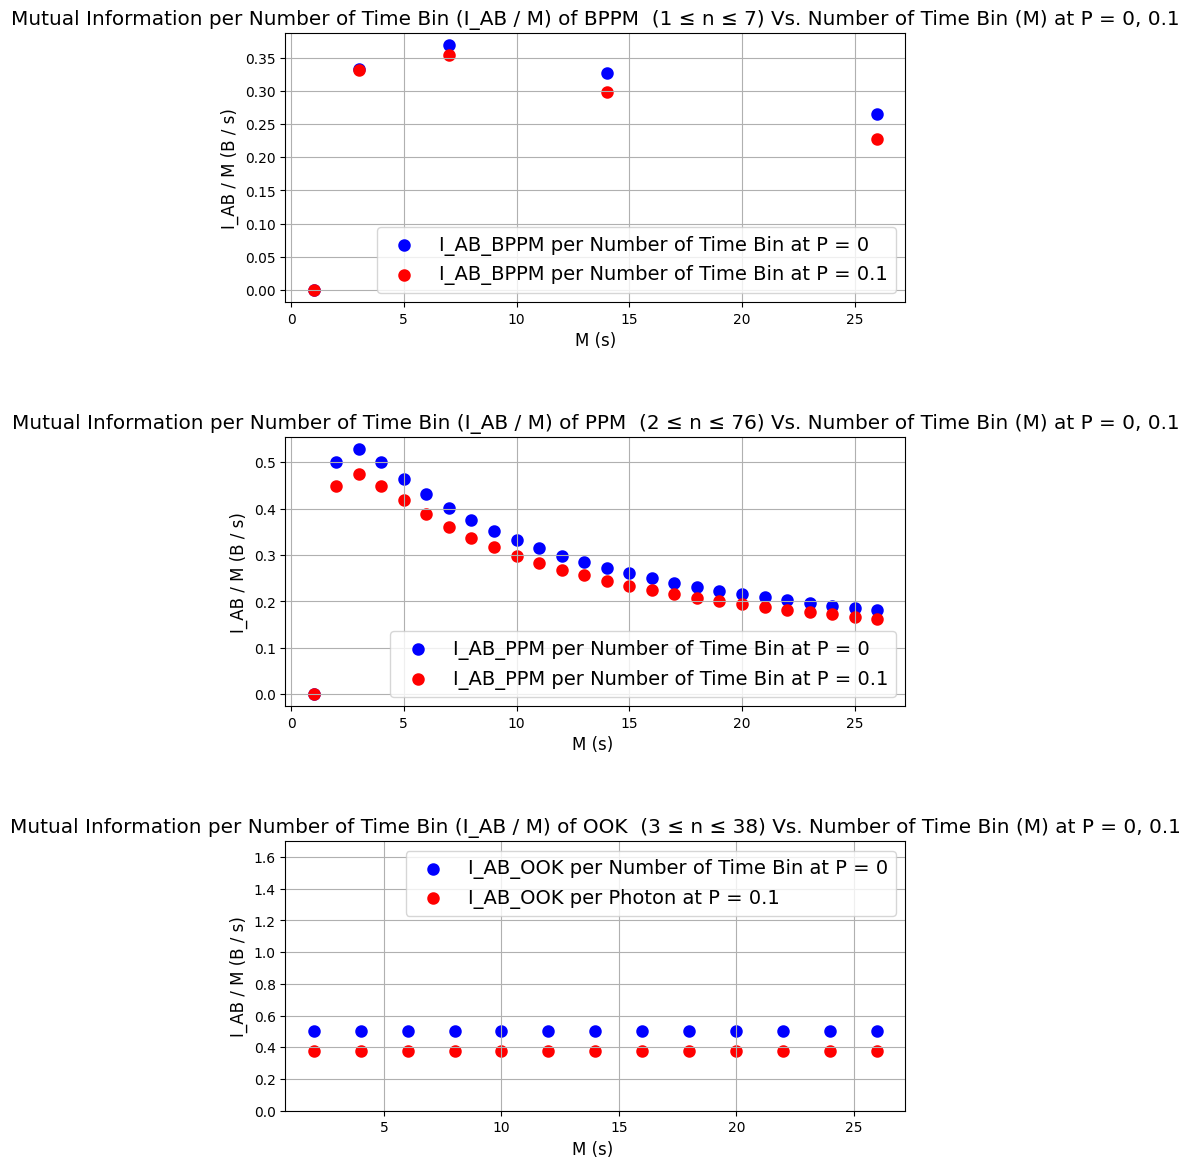

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8, 14))

axs[0].scatter(TimeBin_BPPM_list_0, IperTimeBin_AB_BPPM_list_0, label='I_AB_BPPM per Number of Time Bin at P = 0', color ='blue', linewidth=3, alpha=1)
axs[0].scatter(TimeBin_BPPM_list_0_1, IperTimeBin_AB_BPPM_list_0_1, label='I_AB_BPPM per Number of Time Bin at P = 0.1', color ='red', linewidth=3, alpha=1)
axs[0].set_title('Mutual Information per Number of Time Bin (I_AB / M) of BPPM  (1 \u2264 n \u2264 7) Vs. Number of Time Bin (M) at P = 0, 0.1', fontsize='x-large')
axs[0].set_xlabel('M (s)', fontsize = 12)
axs[0].set_ylabel('I_AB / M (B / s)', fontsize = 12)
axs[0].grid(True)
axs[0].legend(fontsize=14)

axs[1].scatter(TimeBin_PPM_list_0, IperTimeBin_AB_PPM_list_0, label='I_AB_PPM per Number of Time Bin at P = 0', color ='blue', linewidth=3, alpha=1)
axs[1].scatter(TimeBin_PPM_list_0_1, IperTimeBin_AB_PPM_list_0_1, label='I_AB_PPM per Number of Time Bin at P = 0.1', color ='red', linewidth=3, alpha=1)
axs[1].set_title('Mutual Information per Number of Time Bin (I_AB / M) of PPM  (2 \u2264 n \u2264 76) Vs. Number of Time Bin (M) at P = 0, 0.1', fontsize='x-large')
axs[1].set_xlabel('M (s) ', fontsize = 12)
axs[1].set_ylabel('I_AB / M (B / s)', fontsize = 12)
axs[1].grid(True)
axs[1].legend(fontsize=14)

axs[2].scatter(TimeBin_OOK_list_0, IperTimeBin_AB_OOK_list_0, label='I_AB_OOK per Number of Time Bin at P = 0', color ='blue', linewidth=3, alpha=1)
axs[2].scatter(TimeBin_OOK_list_0_1, IperTimeBin_AB_OOK_list_0_1, label='I_AB_OOK per Photon at P = 0.1', color ='red', linewidth=3, alpha=1)
axs[2].set_title('Mutual Information per Number of Time Bin (I_AB / M) of OOK  (3 \u2264 n \u2264 38) Vs. Number of Time Bin (M) at P = 0, 0.1', fontsize='x-large')
axs[2].set_xlabel('M (s) ', fontsize = 12)
axs[2].set_ylabel('I_AB / M (B / s)', fontsize = 12)
axs[2].set_ylim(0, 1.7) 
axs[2].grid(True)
axs[2].legend(fontsize=14)

plt.subplots_adjust(hspace=0.5)
figure.set_facecolor("white")
plt.show()

### Plot on Mutual Information per Photon x Time Bin Vs Time Bin

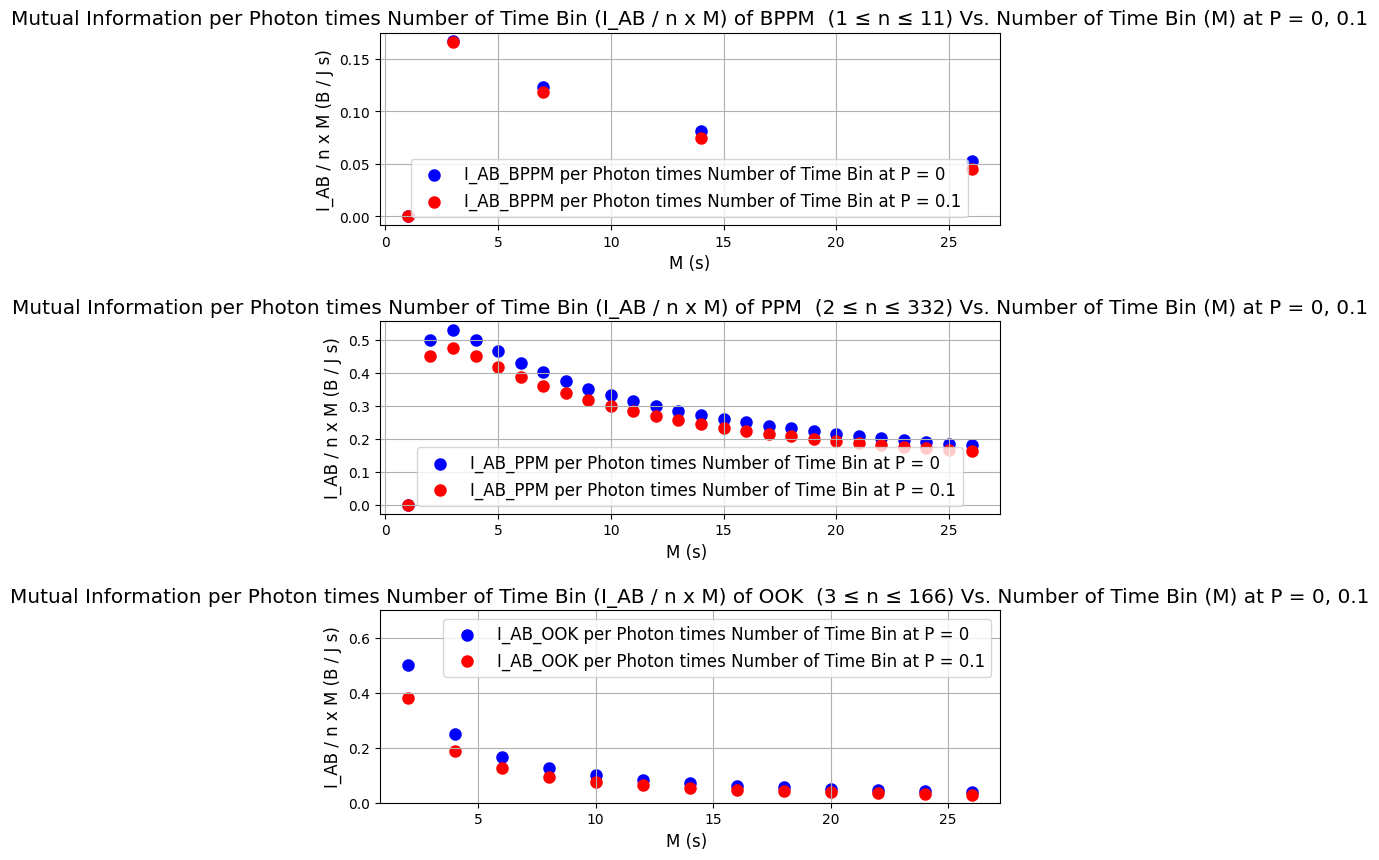

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8, 10))

axs[0].scatter(TimeBin_BPPM_list_0, IperPhotonTimeBin_AB_BPPM_list_0, label='I_AB_BPPM per Photon times Number of Time Bin at P = 0', color ='blue', linewidth=3, alpha=1)
axs[0].scatter(TimeBin_BPPM_list_0_1, IperPhotonTimeBin_AB_BPPM_list_0_1, label='I_AB_BPPM per Photon times Number of Time Bin at P = 0.1', color ='red', linewidth=3, alpha=1)
axs[0].set_title('Mutual Information per Photon times Number of Time Bin (I_AB / n x M) of BPPM  (1 \u2264 n \u2264 11) Vs. Number of Time Bin (M) at P = 0, 0.1', fontsize='x-large')
axs[0].set_xlabel('M (s)', fontsize = 12)
axs[0].set_ylabel('I_AB / n x M (B / J s)', fontsize = 12)
axs[0].grid(True)
axs[0].legend(fontsize=12)

axs[1].scatter(TimeBin_PPM_list_0, IperPhotonTimeBin_AB_PPM_list_0, label='I_AB_PPM per Photon times Number of Time Bin at P = 0', color ='blue', linewidth=3, alpha=1)
axs[1].scatter(TimeBin_PPM_list_0_1, IperPhotonTimeBin_AB_PPM_list_0_1, label='I_AB_PPM per Photon times Number of Time Bin at P = 0.1', color ='red', linewidth=3, alpha=1)
axs[1].set_title('Mutual Information per Photon times Number of Time Bin (I_AB / n x M) of PPM  (2 \u2264 n \u2264 332) Vs. Number of Time Bin (M) at P = 0, 0.1', fontsize='x-large')
axs[1].set_xlabel('M (s) ', fontsize = 12)
axs[1].set_ylabel('I_AB / n x M (B / J s)', fontsize = 12)
axs[1].grid(True)
axs[1].legend(fontsize=12)

axs[2].scatter(TimeBin_OOK_list_0, IperPhotonTimeBin_AB_OOK_list_0, label='I_AB_OOK per Photon times Number of Time Bin at P = 0', color ='blue', linewidth=3, alpha=1)
axs[2].scatter(TimeBin_OOK_list_0_1, IperPhotonTimeBin_AB_OOK_list_0_1, label='I_AB_OOK per Photon times Number of Time Bin at P = 0.1', color ='red', linewidth=3, alpha=1)
axs[2].set_title('Mutual Information per Photon times Number of Time Bin (I_AB / n x M) of OOK  (3 \u2264 n \u2264 166) Vs. Number of Time Bin (M) at P = 0, 0.1', fontsize='x-large')
axs[2].set_xlabel('M (s) ', fontsize = 12)
axs[2].set_ylabel('I_AB / n x M (B / J s)', fontsize = 12)
axs[2].set_ylim(0, 0.7) 
axs[2].grid(True)
axs[2].legend(fontsize=12)

plt.subplots_adjust(hspace=0.5)
figure.set_facecolor("white")
plt.show()

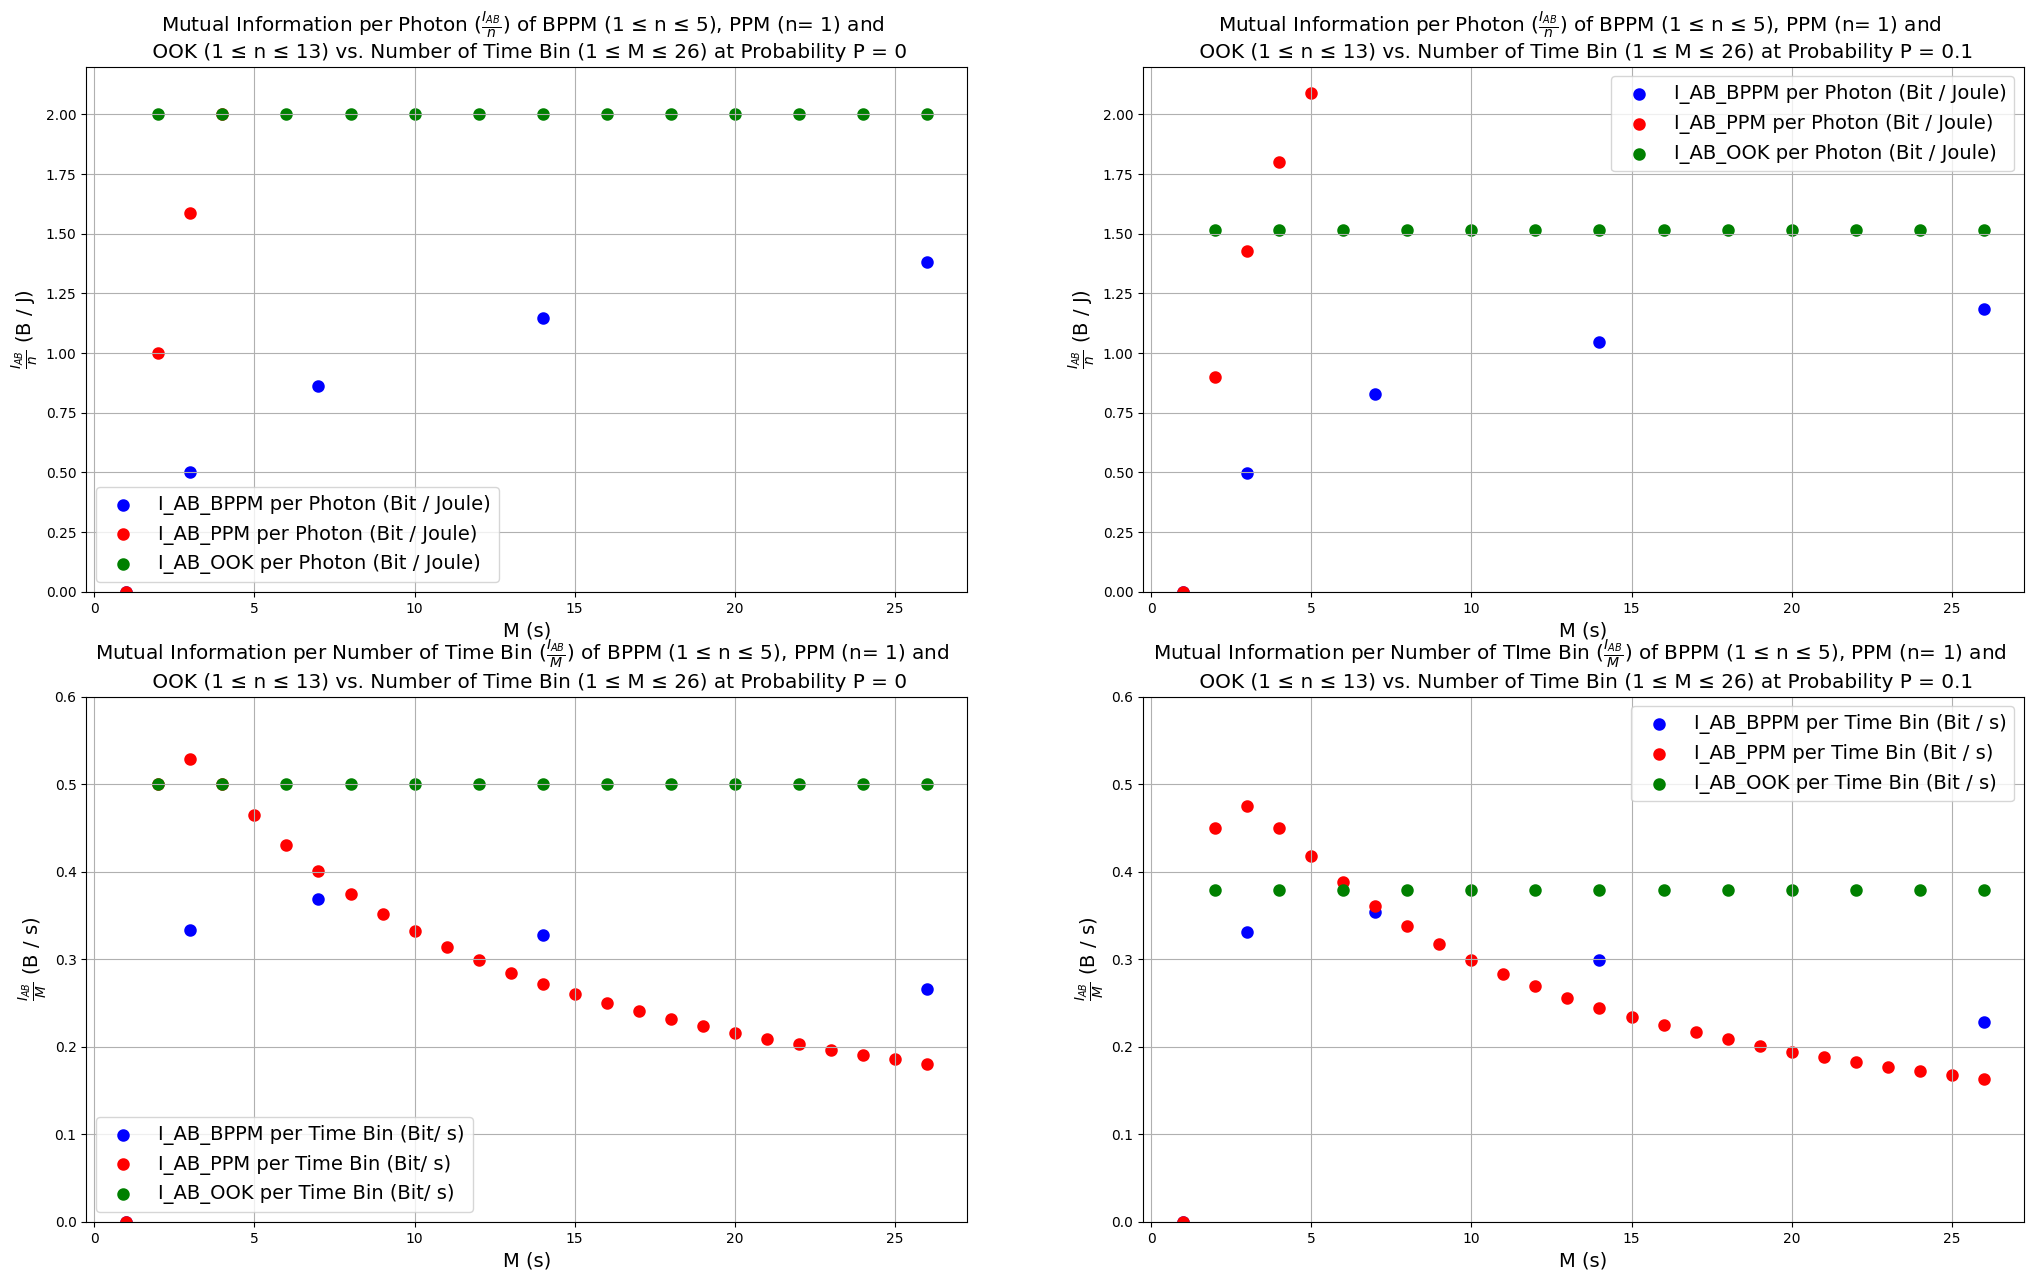

In [ ]:
figure, axis = plt.subplots(2,2,figsize=(25,15))

axis[0, 0].scatter(TimeBin_BPPM_list_0, IperPhoton_AB_BPPM_list_0, label='I_AB_BPPM per Photon (Bit / Joule)', color ='blue', linewidth=3, alpha=1)
axis[0, 0].scatter(TimeBin_PPM_list_0, IperPhoton_AB_PPM_list_0, label='I_AB_PPM per Photon (Bit / Joule)', color ='red', linewidth=3, alpha=1)
axis[0, 0].scatter(TimeBin_OOK_list_0, IperPhoton_AB_OOK_list_0, label='I_AB_OOK per Photon (Bit / Joule)', color ='green', linewidth=3, alpha=1)
axis[0, 0].set_title('Mutual Information per Photon ($\\frac{I_{AB}}{n}$) of BPPM (1 \u2264 n \u2264 5), PPM (n= 1) and  \n OOK (1 \u2264 n \u2264 13) vs. Number of Time Bin (1 \u2264 M \u2264 26) at Probability P = 0', fontsize='x-large')
axis[0, 0].set_xlabel('M (s)', fontsize = 14)
axis[0, 0].set_ylabel('$\\frac{I_{AB}}{n}$ (B / J)', fontsize = 14)
# axis[0, 0].set_xscale('log')
axis[0, 0].set_ylim(0, 2.2)
axis[0, 0].grid(True)
axis[0, 0].legend(fontsize=14)

axis[0, 1].scatter(TimeBin_BPPM_list_0_1, IperPhoton_AB_BPPM_list_0_1, label='I_AB_BPPM per Photon (Bit / Joule)', color ='blue', linewidth=3, alpha=1)
axis[0, 1].scatter(TimeBin_PPM_list_0_1, IperPhoton_AB_PPM_list_0_1, label='I_AB_PPM per Photon (Bit / Joule)', color ='red', linewidth=3, alpha=1)
axis[0, 1].scatter(TimeBin_OOK_list_0_1, IperPhoton_AB_OOK_list_0_1, label='I_AB_OOK per Photon (Bit / Joule)', color ='green', linewidth=3, alpha=1)
axs[2].scatter(TimeBin_OOK_list_0_1, IperPhoton_AB_OOK_list_0_1, label='I_AB_OOK per Photon (Bit / Joule)', color ='blue', linewidth=3, alpha=1)
axis[0, 1].set_title('Mutual Information per Photon ($\\frac{I_{AB}}{n}$) of BPPM (1 \u2264 n \u2264 5), PPM (n= 1) and  \n OOK (1 \u2264 n \u2264 13) vs. Number of Time Bin (1 \u2264 M \u2264 26) at Probability P = 0.1', fontsize='x-large')
axis[0, 1].set_xlabel('M (s)', fontsize = 14)
axis[0, 1].set_ylabel('$\\frac{I_{AB}}{n}$ (B / J)', fontsize = 14)
# axis[0, 1].set_xscale('log')
# plt.ylim(0, 1.7) 
axis[0, 1].set_ylim(0, 2.2)
axis[0, 1].grid(True)
axis[0, 1].legend(fontsize=14)

axis[1, 0].scatter(TimeBin_BPPM_list_0, IperTimeBin_AB_BPPM_list_0, label='I_AB_BPPM per Time Bin (Bit/ s)', color ='blue', linewidth=3, alpha=1)
axis[1, 0].scatter(TimeBin_PPM_list_0, IperTimeBin_AB_PPM_list_0, label='I_AB_PPM per Time Bin (Bit/ s)', color ='red', linewidth=3, alpha=1)
axis[1, 0].scatter(TimeBin_OOK_list_0, IperTimeBin_AB_OOK_list_0, label='I_AB_OOK per Time Bin (Bit/ s)', color ='green', linewidth=3, alpha=1)
axis[1, 0].set_title('Mutual Information per Number of Time Bin ($\\frac{I_{AB}}{M}$) of BPPM (1 \u2264 n \u2264 5), PPM (n= 1) and  \n OOK (1 \u2264 n \u2264 13) vs. Number of Time Bin (1 \u2264 M \u2264 26) at Probability P = 0', fontsize='x-large')
axis[1, 0].set_xlabel('M (s)', fontsize = 14)
axis[1, 0].set_ylabel('$\\frac{I_{AB}}{M}$ (B / s)', fontsize = 14)
# axis[1, 0].set_xscale('log')
axis[1, 0].set_ylim(0, 0.6)
axis[1, 0].grid(True)
axis[1, 0].legend(fontsize=14)

axis[1, 1].scatter(TimeBin_BPPM_list_0_1, IperTimeBin_AB_BPPM_list_0_1, label='I_AB_BPPM per Time Bin (Bit / s)', color ='blue', linewidth=3, alpha=1)
axis[1, 1].scatter(TimeBin_PPM_list_0_1, IperTimeBin_AB_PPM_list_0_1, label='I_AB_PPM per Time Bin (Bit / s)', color ='red', linewidth=3, alpha=1)
axis[1, 1].scatter(TimeBin_OOK_list_0_1, IperTimeBin_AB_OOK_list_0_1, label='I_AB_OOK per Time Bin (Bit / s)', color ='green', linewidth=3, alpha=1)
axis[1, 1].set_title('Mutual Information per Number of TIme Bin ($\\frac{I_{AB}}{M}$) of BPPM (1 \u2264 n \u2264 5), PPM (n= 1) and  \n OOK (1 \u2264 n \u2264 13) vs. Number of Time Bin (1 \u2264 M \u2264 26) at Probability P = 0.1', fontsize='x-large')
axis[1, 1].set_xlabel('M (s)', fontsize = 14)
axis[1, 1].set_ylabel('$\\frac{I_{AB}}{M}$ (B / s)', fontsize = 14)
# axis[1, 1].set_xscale('log')
axis[1, 1].set_ylim(0, 0.6)
axis[1, 1].grid(True)
axis[1, 1].legend(fontsize=14)

figure.set_facecolor("white")
# plt.savefig('protocol/MI_Power_4schemes_Plot.png', dpi=450, bbox_inches='tight')
plt.show()

/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_87177/3487426454.py:82: UserWarning: AutoMinorLocator does not work on logarithmic scales
  plt.savefig('protocol/MI_Power_4schemes_Plot.png', dpi=450, bbox_inches='tight')


FileNotFoundError: [Errno 2] No such file or directory: '/Users/daai6ga1hou2/Documents/GitHub/Courses/Physics/KTH_Master_Thesis/MasterThesisSimulation/protocol/MI_Power_4schemes_Plot.png'

/Users/daai6ga1hou2/anaconda3/envs/qkd-env/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: AutoMinorLocator does not work on logarithmic scales
  func(*args, **kwargs)
/Users/daai6ga1hou2/anaconda3/envs/qkd-env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: AutoMinorLocator does not work on logarithmic scales
  fig.canvas.print_figure(bytes_io, **kw)


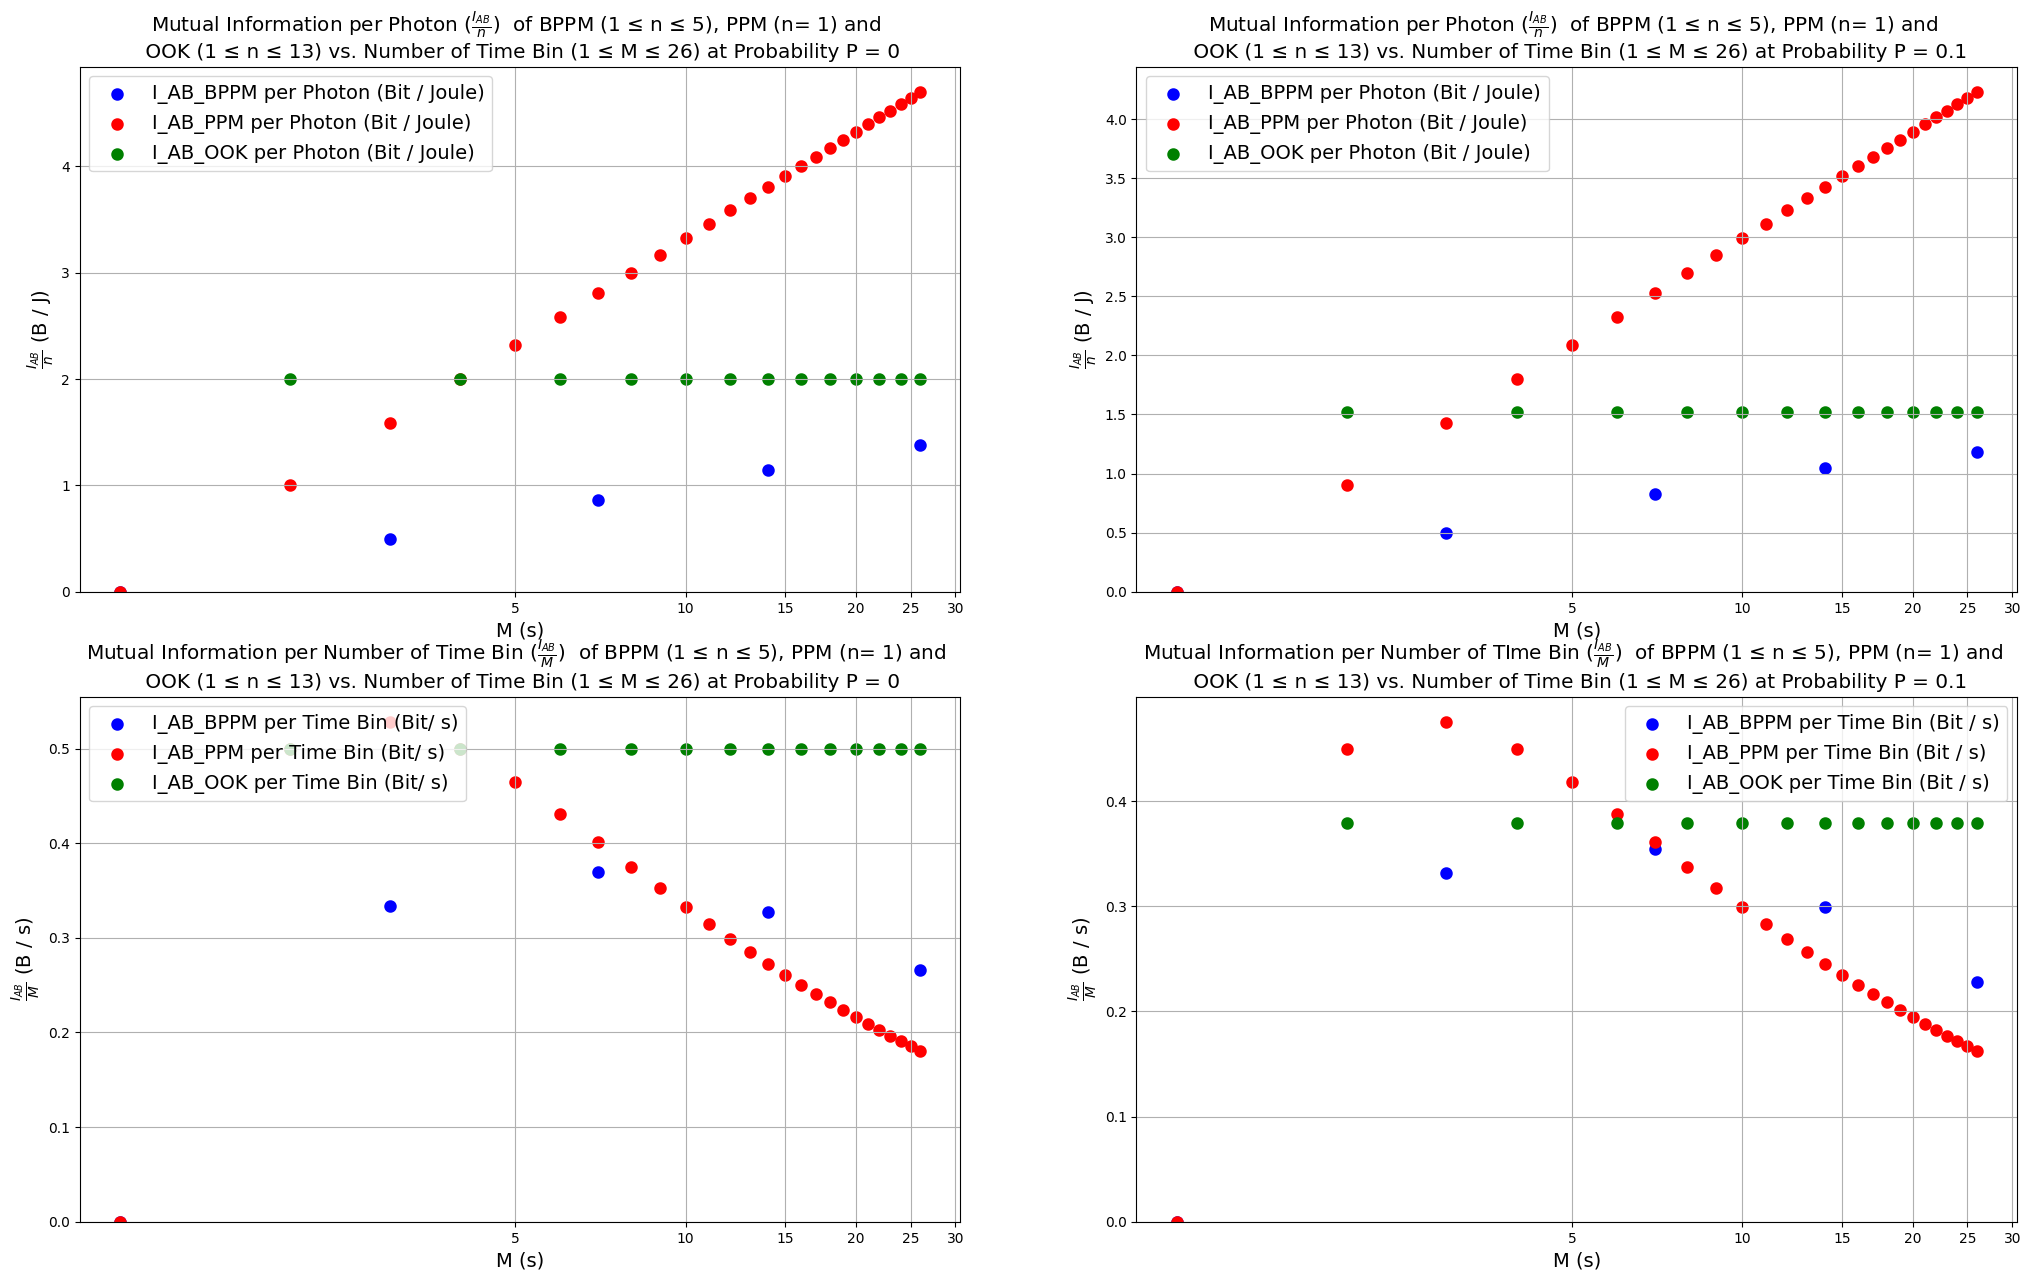

In [ ]:
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import AutoLocator, AutoMinorLocator

# Set the tick formatter for the x-axis
formatter = ScalarFormatter(useOffset=False)

figure, axis = plt.subplots(2,2,figsize=(25,15))

axis[0, 0].scatter(TimeBin_BPPM_list_0, IperPhoton_AB_BPPM_list_0, label='I_AB_BPPM per Photon (Bit / Joule)', color ='blue', linewidth=3, alpha=1)
axis[0, 0].scatter(TimeBin_PPM_list_0, IperPhoton_AB_PPM_list_0, label='I_AB_PPM per Photon (Bit / Joule)', color ='red', linewidth=3, alpha=1)
axis[0, 0].scatter(TimeBin_OOK_list_0, IperPhoton_AB_OOK_list_0, label='I_AB_OOK per Photon (Bit / Joule)', color ='green', linewidth=3, alpha=1)

axis[0, 0].set_xscale('log', base = 2)
axis[0, 0].xaxis.set_major_formatter(formatter)
# Set the tick locators and formatters for the x-axis
axis[0, 0].xaxis.set_major_locator(AutoLocator())
axis[0, 0].xaxis.set_minor_locator(AutoMinorLocator())
axis[0, 0].xaxis.set_tick_params(which='both', labelsize=10)

axis[0, 0].set_title('Mutual Information per Photon ($\\frac{I_{AB}}{n}$)  of BPPM (1 \u2264 n \u2264 5), PPM (n= 1) and  \n OOK (1 \u2264 n \u2264 13) vs. Number of Time Bin (1 \u2264 M \u2264 26) at Probability P = 0', fontsize='x-large')
axis[0, 0].set_xlabel('M (s)', fontsize = 14)
axis[0, 0].set_ylabel('$\\frac{I_{AB}}{n}$ (B / J)', fontsize = 14)
axis[0, 0].set_ylim(0)
axis[0, 0].grid(True)
axis[0, 0].legend(fontsize=14)

axis[0, 1].scatter(TimeBin_BPPM_list_0_1, IperPhoton_AB_BPPM_list_0_1, label='I_AB_BPPM per Photon (Bit / Joule)', color ='blue', linewidth=3, alpha=1)
axis[0, 1].scatter(TimeBin_PPM_list_0_1, IperPhoton_AB_PPM_list_0_1, label='I_AB_PPM per Photon (Bit / Joule)', color ='red', linewidth=3, alpha=1)
axis[0, 1].scatter(TimeBin_OOK_list_0_1, IperPhoton_AB_OOK_list_0_1, label='I_AB_OOK per Photon (Bit / Joule)', color ='green', linewidth=3, alpha=1)

axis[0, 1].set_xscale('log')
axis[0, 1].xaxis.set_major_formatter(formatter)
# Set the tick locators and formatters for the x-axis
axis[0, 1].xaxis.set_major_locator(AutoLocator())
axis[0, 1].xaxis.set_minor_locator(AutoMinorLocator())
axis[0, 1].xaxis.set_tick_params(which='both', labelsize=10)

axis[0, 1].set_title('Mutual Information per Photon ($\\frac{I_{AB}}{n}$)  of BPPM (1 \u2264 n \u2264 5), PPM (n= 1) and  \n OOK (1 \u2264 n \u2264 13) vs. Number of Time Bin (1 \u2264 M \u2264 26) at Probability P = 0.1', fontsize='x-large')
axis[0, 1].set_xlabel('M (s)', fontsize = 14)
axis[0, 1].set_ylabel('$\\frac{I_{AB}}{n}$ (B / J)', fontsize = 14)
axis[0, 1].set_ylim(0)
axis[0, 1].grid(True)
axis[0, 1].legend(fontsize=14)

axis[1, 0].scatter(TimeBin_BPPM_list_0, IperTimeBin_AB_BPPM_list_0, label='I_AB_BPPM per Time Bin (Bit/ s)', color ='blue', linewidth=3, alpha=1)
axis[1, 0].scatter(TimeBin_PPM_list_0, IperTimeBin_AB_PPM_list_0, label='I_AB_PPM per Time Bin (Bit/ s)', color ='red', linewidth=3, alpha=1)
axis[1, 0].scatter(TimeBin_OOK_list_0, IperTimeBin_AB_OOK_list_0, label='I_AB_OOK per Time Bin (Bit/ s)', color ='green', linewidth=3, alpha=1)

axis[1, 0].set_xscale('log')
axis[1, 0].xaxis.set_major_formatter(formatter)
# Set the tick locators and formatters for the x-axis
axis[1, 0].xaxis.set_major_locator(AutoLocator())
axis[1, 0].xaxis.set_minor_locator(AutoMinorLocator())
axis[1, 0].xaxis.set_tick_params(which='both', labelsize=10)

axis[1, 0].set_title('Mutual Information per Number of Time Bin ($\\frac{I_{AB}}{M}$)  of BPPM (1 \u2264 n \u2264 5), PPM (n= 1) and  \n OOK (1 \u2264 n \u2264 13) vs. Number of Time Bin (1 \u2264 M \u2264 26) at Probability P = 0', fontsize='x-large')
axis[1, 0].set_xlabel('M (s)', fontsize = 14)
axis[1, 0].set_ylabel('$\\frac{I_{AB}}{M}$ (B / s)', fontsize = 14)
axis[1, 0].set_ylim(0)
axis[1, 0].grid(True)
axis[1, 0].legend(loc='upper left',fontsize=14)

axis[1, 1].scatter(TimeBin_BPPM_list_0_1, IperTimeBin_AB_BPPM_list_0_1, label='I_AB_BPPM per Time Bin (Bit / s)', color ='blue', linewidth=3, alpha=1)
axis[1, 1].scatter(TimeBin_PPM_list_0_1, IperTimeBin_AB_PPM_list_0_1, label='I_AB_PPM per Time Bin (Bit / s)', color ='red', linewidth=3, alpha=1)
axis[1, 1].scatter(TimeBin_OOK_list_0_1, IperTimeBin_AB_OOK_list_0_1, label='I_AB_OOK per Time Bin (Bit / s)', color ='green', linewidth=3, alpha=1)
axis[1, 1].set_xscale('log')
axis[1, 1].xaxis.set_major_formatter(formatter)
# Set the tick locators and formatters for the x-axis
axis[1, 1].xaxis.set_major_locator(AutoLocator())
axis[1, 1].xaxis.set_minor_locator(AutoMinorLocator())
axis[1, 1].xaxis.set_tick_params(which='both', labelsize=10)

axis[1, 1].set_title('Mutual Information per Number of TIme Bin ($\\frac{I_{AB}}{M}$)  of BPPM (1 \u2264 n \u2264 5), PPM (n= 1) and  \n OOK (1 \u2264 n \u2264 13) vs. Number of Time Bin (1 \u2264 M \u2264 26) at Probability P = 0.1', fontsize='x-large')
axis[1, 1].set_xlabel('M (s)', fontsize = 14)
axis[1, 1].set_ylabel('$\\frac{I_{AB}}{M}$ (B / s)', fontsize = 14)

axis[1, 1].set_ylim(0)
axis[1, 1].grid(True)
axis[1, 1].legend(fontsize=14)

figure.set_facecolor("white")
plt.savefig('protocol/MI_Power_4schemes_Plot.png', dpi=450, bbox_inches='tight')
plt.show()

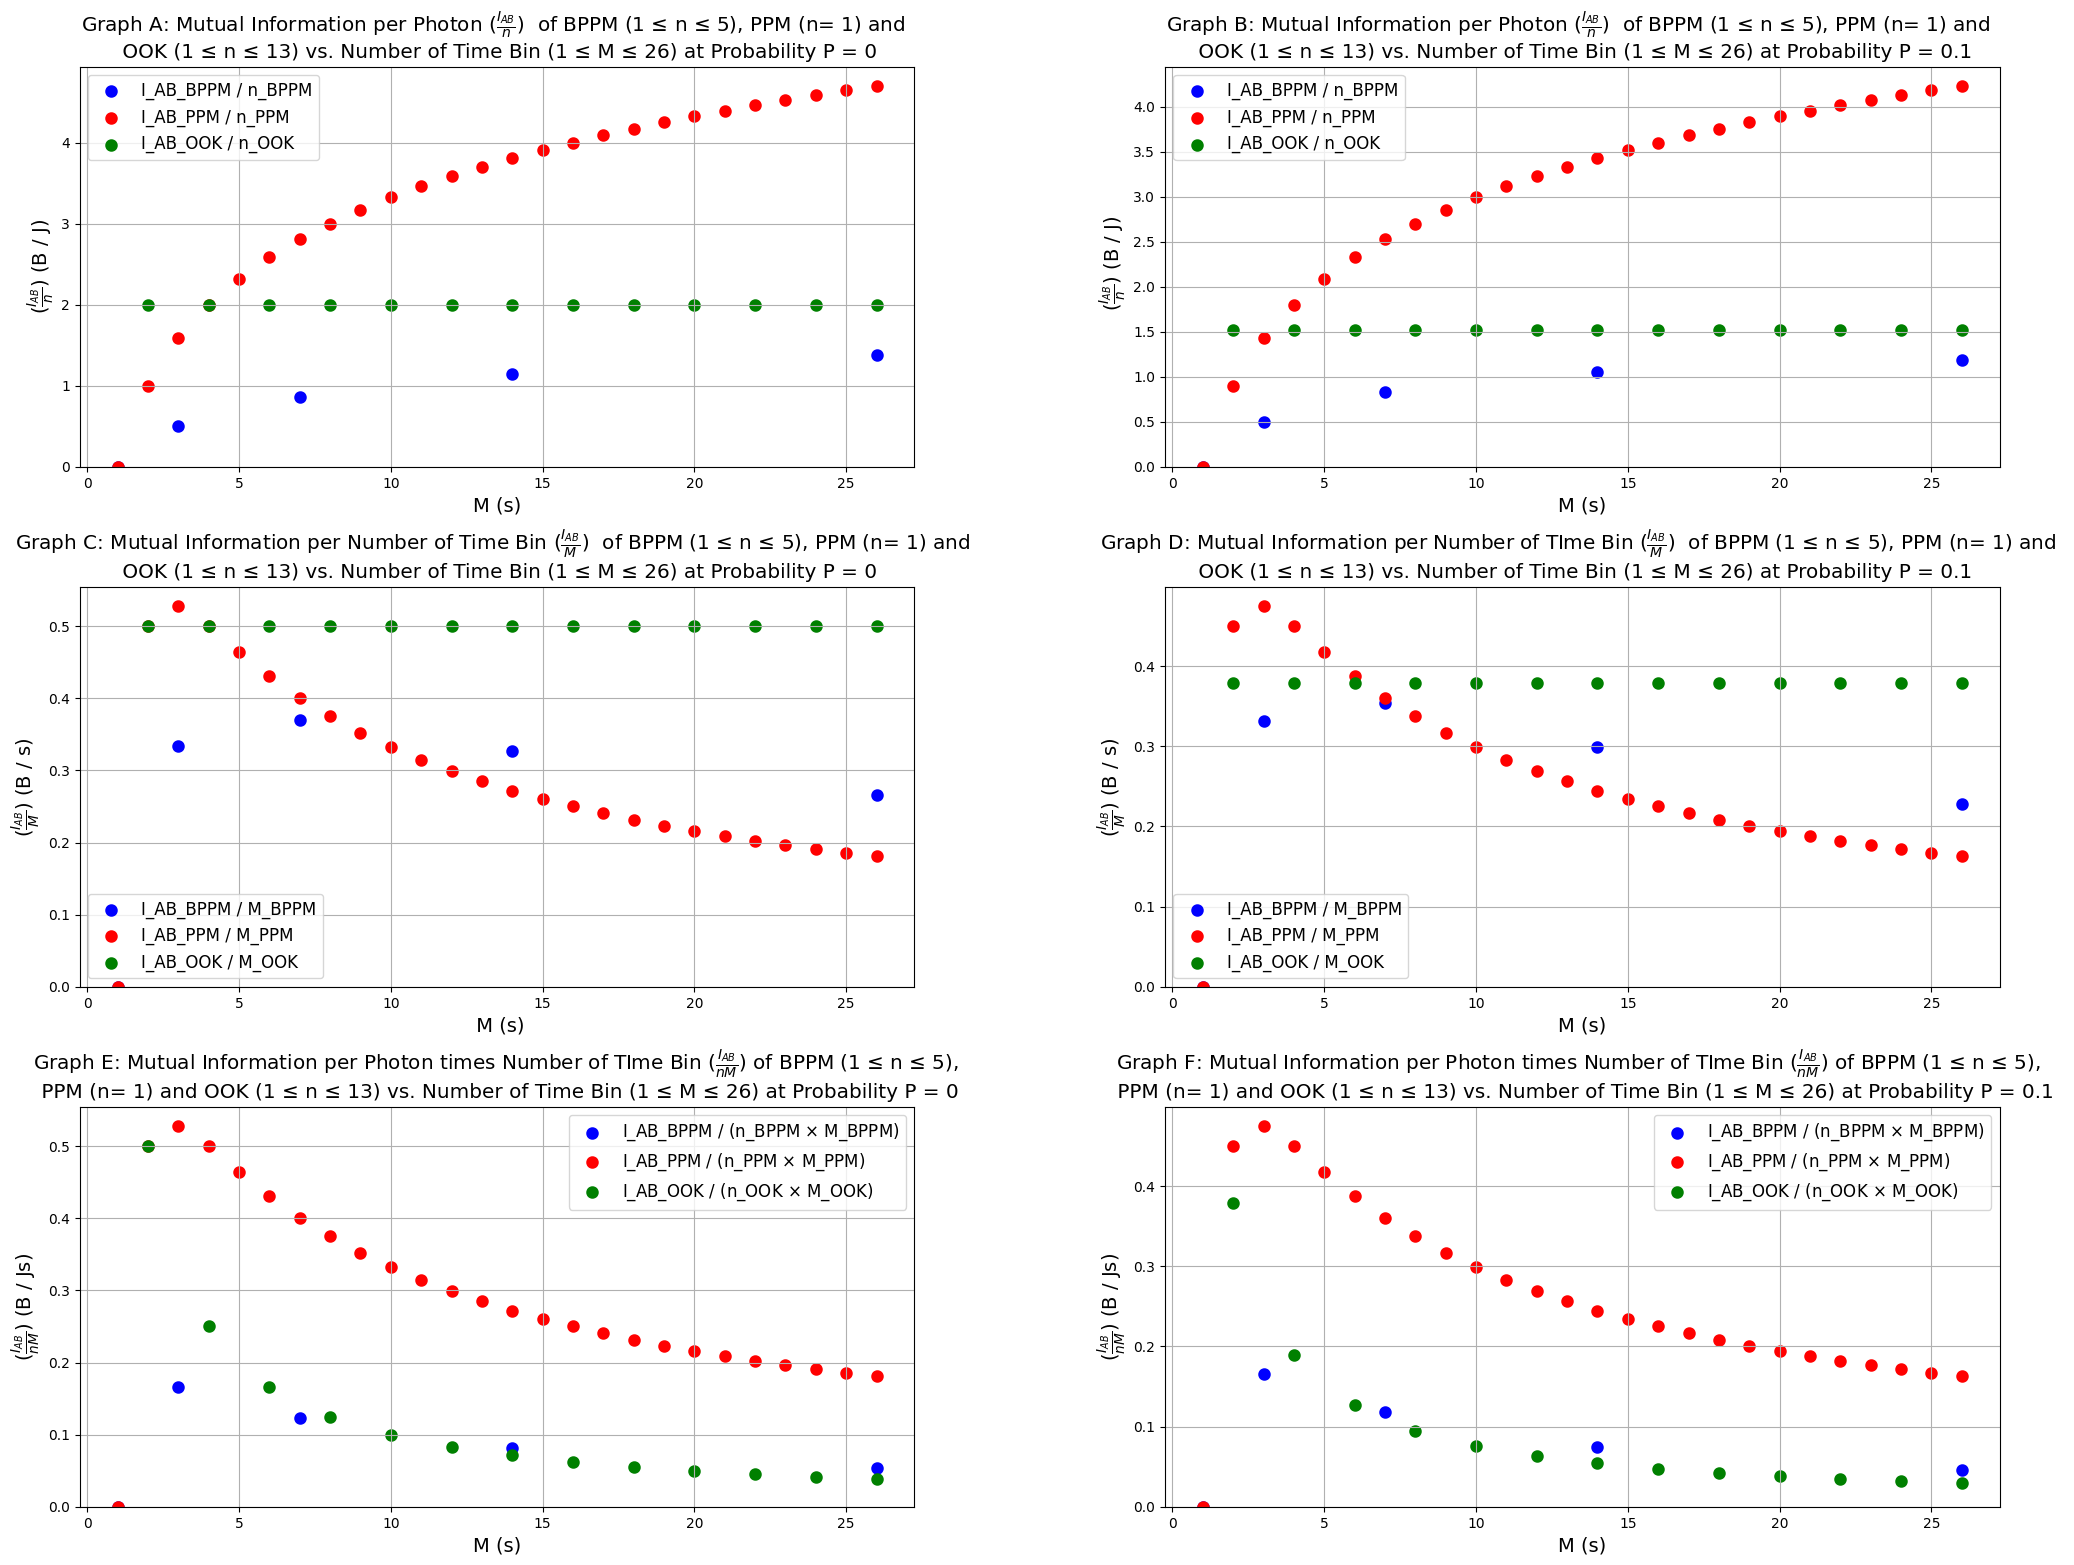

In [ ]:
figure, axis = plt.subplots(3,2,figsize=(24,18))

axis[0, 0].scatter(TimeBin_BPPM_list_0, IperPhoton_AB_BPPM_list_0, label='I_AB_BPPM / n_BPPM', color ='blue', linewidth=3, alpha=1)
axis[0, 0].scatter(TimeBin_PPM_list_0, IperPhoton_AB_PPM_list_0, label='I_AB_PPM / n_PPM', color ='red', linewidth=3, alpha=1)
axis[0, 0].scatter(TimeBin_OOK_list_0, IperPhoton_AB_OOK_list_0, label='I_AB_OOK / n_OOK', color ='green', linewidth=3, alpha=1)
axis[0, 0].set_title('Graph A: Mutual Information per Photon ($\\frac{I_{AB}}{n}$)  of BPPM (1 \u2264 n \u2264 5), PPM (n= 1) and  \n OOK (1 \u2264 n \u2264 13) vs. Number of Time Bin (1 \u2264 M \u2264 26) at Probability P = 0', fontsize='x-large')
axis[0, 0].set_xlabel('M (s)', fontsize = 14)
axis[0, 0].set_ylabel('($\\frac{I_{AB}}{n}$) (B / J)', fontsize = 14)
# axis[0, 0].set_xscale('log')
axis[0, 0].set_ylim(0)
axis[0, 0].grid(True)
axis[0, 0].legend(fontsize=12)

axis[0, 1].scatter(TimeBin_BPPM_list_0_1, IperPhoton_AB_BPPM_list_0_1, label='I_AB_BPPM / n_BPPM', color ='blue', linewidth=3, alpha=1)
axis[0, 1].scatter(TimeBin_PPM_list_0_1, IperPhoton_AB_PPM_list_0_1, label='I_AB_PPM / n_PPM', color ='red', linewidth=3, alpha=1)
axis[0, 1].scatter(TimeBin_OOK_list_0_1, IperPhoton_AB_OOK_list_0_1, label='I_AB_OOK / n_OOK', color ='green', linewidth=3, alpha=1)
axs[2].scatter(TimeBin_OOK_list_0, IperPhoton_AB_OOK_list_0, label='I_AB_OOK per Photon (Bit / Joule)', color ='blue', linewidth=3, alpha=1)
axis[0, 1].set_title('Graph B: Mutual Information per Photon ($\\frac{I_{AB}}{n}$)  of BPPM (1 \u2264 n \u2264 5), PPM (n= 1) and  \n OOK (1 \u2264 n \u2264 13) vs. Number of Time Bin (1 \u2264 M \u2264 26) at Probability P = 0.1', fontsize='x-large')
axis[0, 1].set_xlabel('M (s)', fontsize = 14)
axis[0, 1].set_ylabel(' ($\\frac{I_{AB}}{n}$) (B / J)', fontsize = 14)
# axis[0, 1].set_xscale('log')
axis[0, 1].set_ylim(0)
axis[0, 1].grid(True)
axis[0, 1].legend(fontsize=12)

axis[1, 0].scatter(TimeBin_BPPM_list_0, IperTimeBin_AB_BPPM_list_0, label='I_AB_BPPM / M_BPPM', color ='blue', linewidth=3, alpha=1)
axis[1, 0].scatter(TimeBin_PPM_list_0, IperTimeBin_AB_PPM_list_0, label='I_AB_PPM / M_PPM', color ='red', linewidth=3, alpha=1)
axis[1, 0].scatter(TimeBin_OOK_list_0, IperTimeBin_AB_OOK_list_0, label='I_AB_OOK / M_OOK', color ='green', linewidth=3, alpha=1)
axis[1, 0].set_title('Graph C: Mutual Information per Number of Time Bin ($\\frac{I_{AB}}{M}$)  of BPPM (1 \u2264 n \u2264 5), PPM (n= 1) and  \n OOK (1 \u2264 n \u2264 13) vs. Number of Time Bin (1 \u2264 M \u2264 26) at Probability P = 0', fontsize='x-large')
axis[1, 0].set_xlabel(' M (s)', fontsize = 14)
axis[1, 0].set_ylabel('($\\frac{I_{AB}}{M}$) (B / s)', fontsize = 14)
# axis[1, 0].set_xscale('log')
axis[1, 0].set_ylim(0)
axis[1, 0].grid(True)
axis[1, 0].legend(fontsize=12)

axis[1, 1].scatter(TimeBin_BPPM_list_0_1, IperTimeBin_AB_BPPM_list_0_1, label='I_AB_BPPM / M_BPPM', color ='blue', linewidth=3, alpha=1)
axis[1, 1].scatter(TimeBin_PPM_list_0_1, IperTimeBin_AB_PPM_list_0_1, label='I_AB_PPM / M_PPM', color ='red', linewidth=3, alpha=1)
axis[1, 1].scatter(TimeBin_OOK_list_0_1, IperTimeBin_AB_OOK_list_0_1, label='I_AB_OOK / M_OOK', color ='green', linewidth=3, alpha=1)
axis[1, 1].set_title('Graph D: Mutual Information per Number of TIme Bin ($\\frac{I_{AB}}{M}$)  of BPPM (1 \u2264 n \u2264 5), PPM (n= 1) and  \n OOK (1 \u2264 n \u2264 13) vs. Number of Time Bin (1 \u2264 M \u2264 26) at Probability P = 0.1', fontsize='x-large')
axis[1, 1].set_xlabel('M (s)', fontsize = 14)
axis[1, 1].set_ylabel('($\\frac{I_{AB}}{M}$) (B / s)', fontsize = 14)
# axis[1, 1].set_xscale('log')
axis[1, 1].set_ylim(0)
axis[1, 1].grid(True)
axis[1, 1].legend(loc = 'lower left', fontsize=12)

axis[2, 0].scatter(TimeBin_BPPM_list_0, IperPhotonTimeBin_AB_BPPM_list_0, label='I_AB_BPPM / (n_BPPM $\\times$ M_BPPM)', color ='blue', linewidth=3, alpha=1)
axis[2, 0].scatter(TimeBin_PPM_list_0, IperPhotonTimeBin_AB_PPM_list_0, label='I_AB_PPM / (n_PPM $\\times$ M_PPM)', color ='red', linewidth=3, alpha=1)
axis[2, 0].scatter(TimeBin_OOK_list_0, IperPhotonTimeBin_AB_OOK_list_0, label='I_AB_OOK / (n_OOK $\\times$ M_OOK)', color ='green', linewidth=3, alpha=1)
axis[2, 0].set_title('Graph E: Mutual Information per Photon times Number of TIme Bin ($\\frac{I_{AB}}{n M}$) of BPPM (1 \u2264 n \u2264 5), \n PPM (n= 1) and OOK (1 \u2264 n \u2264 13) vs. Number of Time Bin (1 \u2264 M \u2264 26) at Probability P = 0', fontsize='x-large')
axis[2, 0].set_xlabel('M (s)', fontsize = 14)
axis[2, 0].set_ylabel('($\\frac{I_{AB}}{n M}$) (B / Js)', fontsize = 14)
# axis[2, 0].set_xscale('log')
axis[2, 0].set_ylim(0)
axis[2, 0].grid(True)
axis[2, 0].legend(fontsize=12)

axis[2, 1].scatter(TimeBin_BPPM_list_0_1, IperPhotonTimeBin_AB_BPPM_list_0_1, label='I_AB_BPPM / (n_BPPM $\\times$ M_BPPM)', color ='blue', linewidth=3, alpha=1)
axis[2, 1].scatter(TimeBin_PPM_list_0_1, IperPhotonTimeBin_AB_PPM_list_0_1, label='I_AB_PPM / (n_PPM $\\times$ M_PPM)', color ='red', linewidth=3, alpha=1)
axis[2, 1].scatter(TimeBin_OOK_list_0_1, IperPhotonTimeBin_AB_OOK_list_0_1, label='I_AB_OOK / (n_OOK $\\times$ M_OOK)', color ='green', linewidth=3, alpha=1)
axis[2, 1].set_title('Graph F: Mutual Information per Photon times Number of TIme Bin ($\\frac{I_{AB}}{n M}$) of BPPM (1 \u2264 n \u2264 5),  \n PPM (n= 1) and OOK (1 \u2264 n \u2264 13) vs. Number of Time Bin (1 \u2264 M \u2264 26) at Probability P = 0.1', fontsize='x-large')
axis[2, 1].set_xlabel('M (s)', fontsize = 14)
axis[2, 1].set_ylabel('($\\frac{I_{AB}}{n M}$) (B / Js)', fontsize = 14)
# axis[2, 1].set_xscale('log')
axis[2, 1].set_ylim(0)
axis[2, 1].grid(True)
axis[2, 1].legend(fontsize=12)

figure.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.3, hspace=0.3)
figure.set_facecolor("white")
plt.savefig('protocol/3NewMetrics.png', dpi=450, bbox_inches='tight')
plt.show()

/var/folders/nd/4tv7bl7d4ys_1zhq177b1_qr0000gn/T/ipykernel_4645/194215458.py:140: UserWarning: AutoMinorLocator does not work with logarithmic scale
  plt.savefig('protocol/3NewMetricsLog.png', dpi=450, bbox_inches='tight')


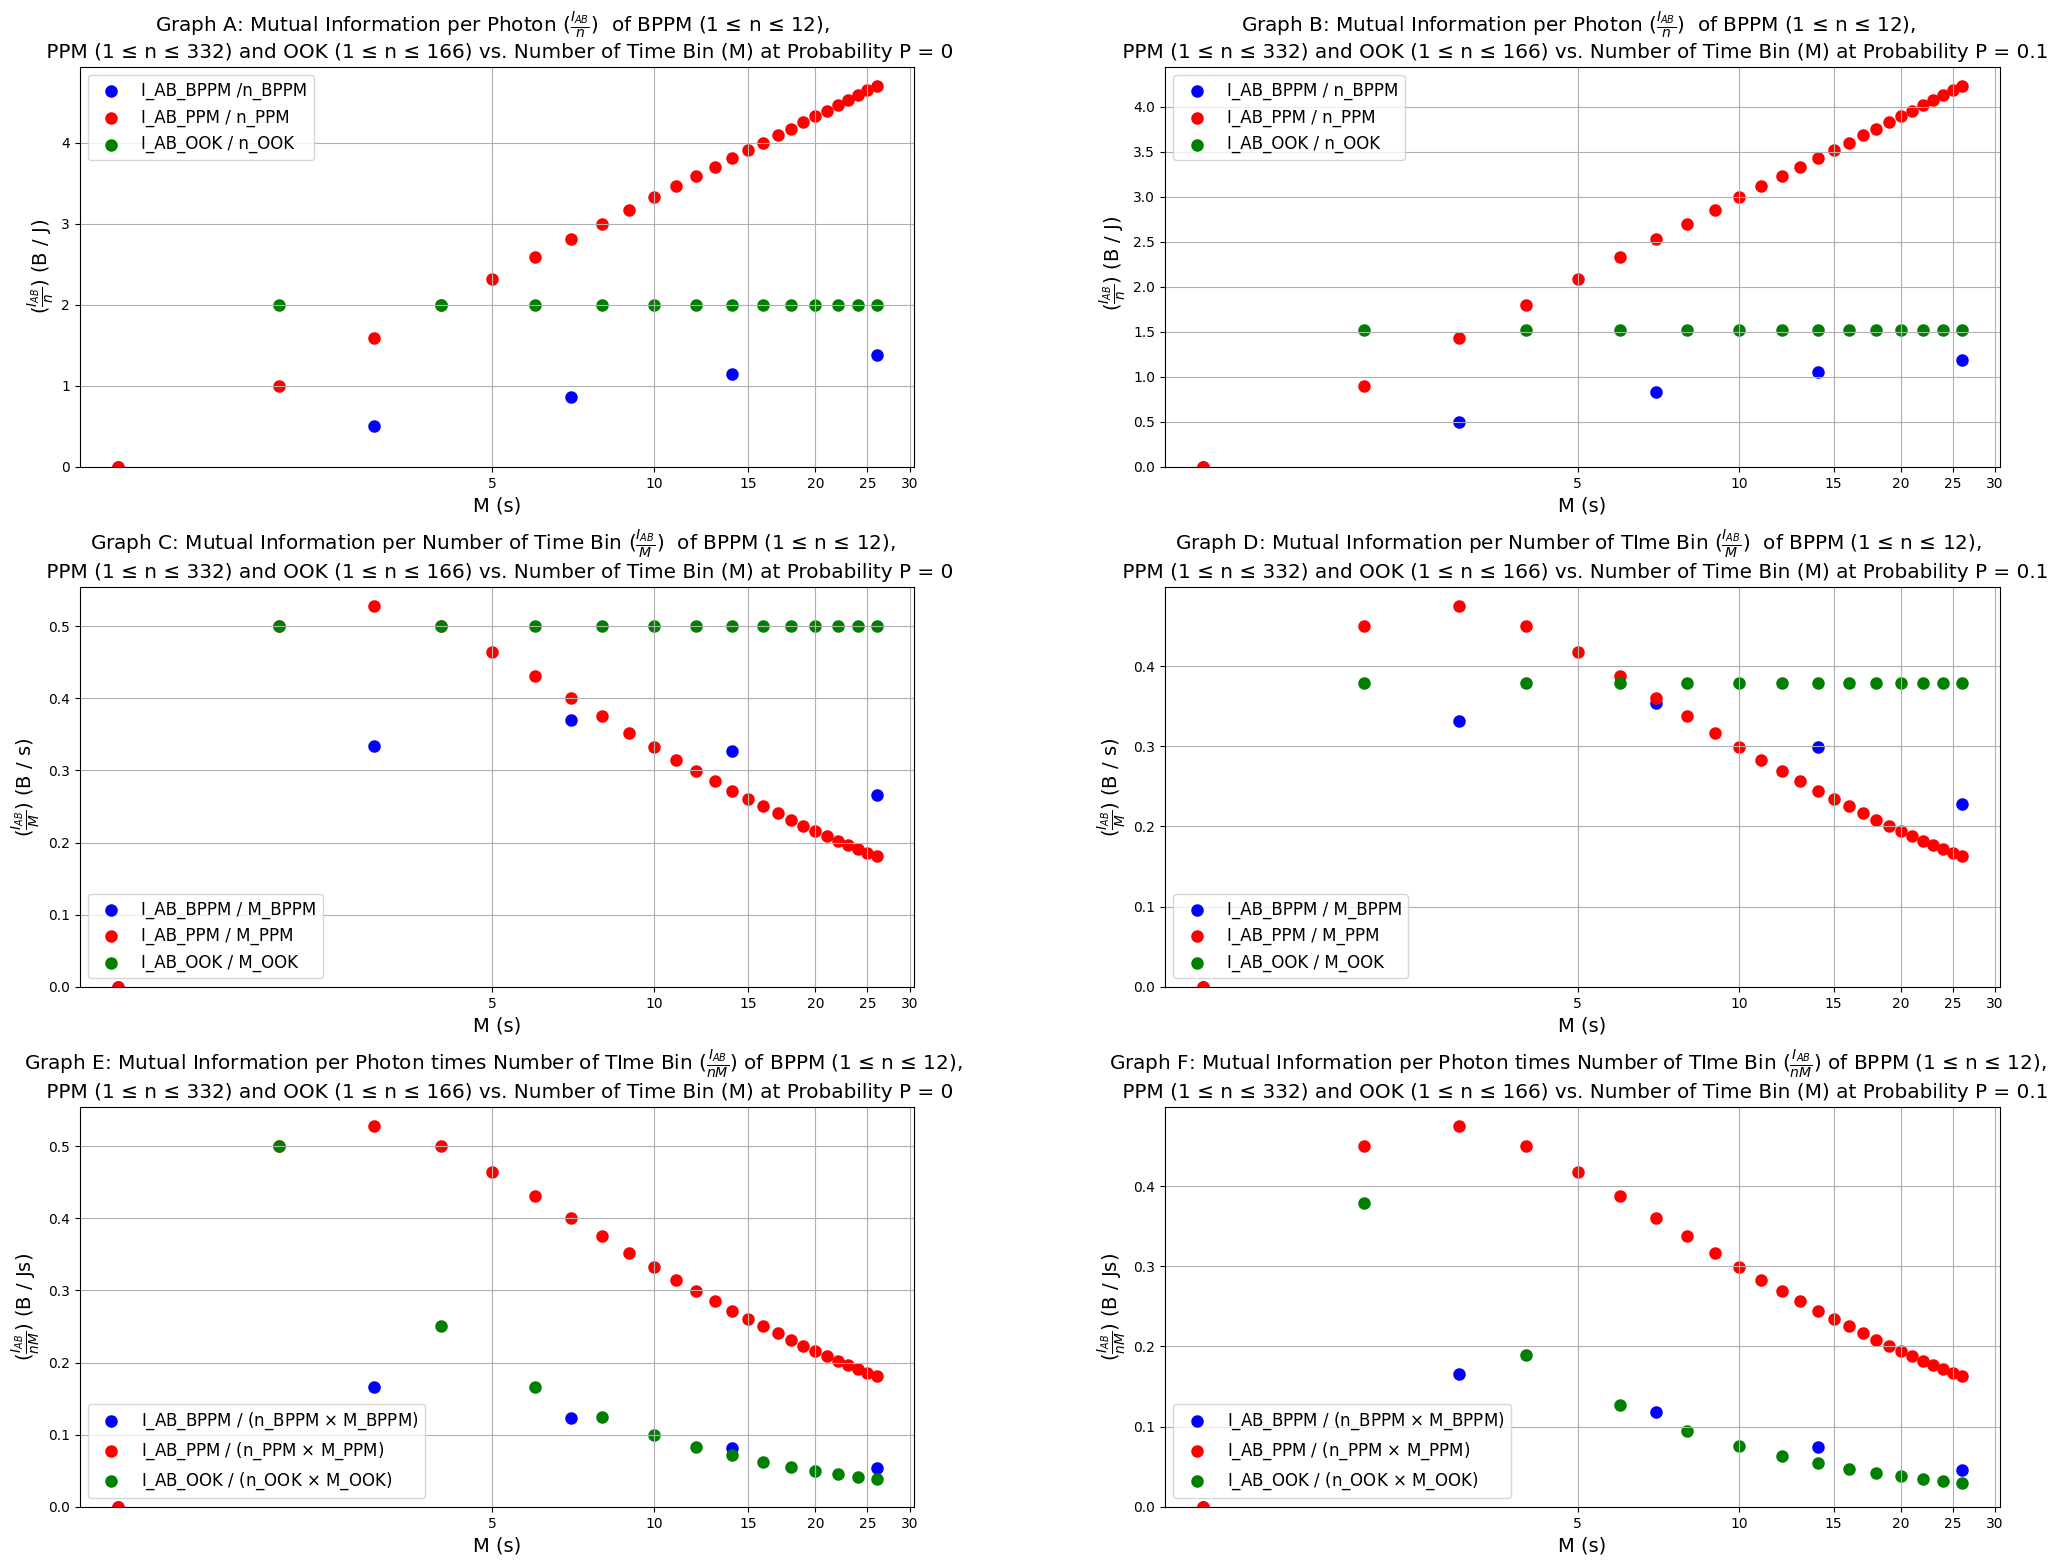

In [ ]:
figure, axis = plt.subplots(3,2,figsize=(24,18))

axis[0, 0].scatter(TimeBin_BPPM_list_0, IperPhoton_AB_BPPM_list_0, label='I_AB_BPPM /n_BPPM', color ='blue', linewidth=3, alpha=1)
axis[0, 0].scatter(TimeBin_PPM_list_0, IperPhoton_AB_PPM_list_0, label='I_AB_PPM / n_PPM', color ='red', linewidth=3, alpha=1)
axis[0, 0].scatter(TimeBin_OOK_list_0, IperPhoton_AB_OOK_list_0, label='I_AB_OOK / n_OOK', color ='green', linewidth=3, alpha=1)
axis[0, 0].set_xscale('log', base = 2)
axis[0, 0].xaxis.set_major_formatter(formatter)
# Set the tick locators and formatters for the x-axis
axis[0, 0].xaxis.set_major_locator(AutoLocator())
axis[0, 0].xaxis.set_minor_locator(AutoMinorLocator())
axis[0, 0].xaxis.set_tick_params(which='both', labelsize=10)

axis[0, 0].set_title('Graph A: Mutual Information per Photon ($\\frac{I_{AB}}{n}$)  of BPPM (1 \u2264 n \u2264 12),  \n PPM (1 \u2264 n \u2264 332) and OOK (1 \u2264 n \u2264 166) vs. Number of Time Bin (M) at Probability P = 0', fontsize='x-large')
axis[0, 0].set_xlabel('M (s)', fontsize = 14)
axis[0, 0].set_ylabel('($\\frac{I_{AB}}{n}$) (B / J)', fontsize = 14)
axis[0, 0].set_ylim(0)
axis[0, 0].grid(True)
axis[0, 0].legend(fontsize=12)







axis[0, 1].scatter(TimeBin_BPPM_list_0_1, IperPhoton_AB_BPPM_list_0_1, label='I_AB_BPPM / n_BPPM', color ='blue', linewidth=3, alpha=1)
axis[0, 1].scatter(TimeBin_PPM_list_0_1, IperPhoton_AB_PPM_list_0_1, label='I_AB_PPM / n_PPM', color ='red', linewidth=3, alpha=1)
axis[0, 1].scatter(TimeBin_OOK_list_0_1, IperPhoton_AB_OOK_list_0_1, label='I_AB_OOK / n_OOK', color ='green', linewidth=3, alpha=1)

axis[0, 1].set_xscale('log', base = 2)
axis[0, 1].xaxis.set_major_formatter(formatter)
# Set the tick locators and formatters for the x-axis
axis[0, 1].xaxis.set_major_locator(AutoLocator())
axis[0, 1].xaxis.set_minor_locator(AutoMinorLocator())
axis[0, 1].xaxis.set_tick_params(which='both', labelsize=10)

axis[0, 1].set_title('Graph B: Mutual Information per Photon ($\\frac{I_{AB}}{n}$)  of BPPM (1 \u2264 n \u2264 12),  \n PPM (1 \u2264 n \u2264 332) and OOK (1 \u2264 n \u2264 166) vs. Number of Time Bin (M) at Probability P = 0.1', fontsize='x-large')
axis[0, 1].set_xlabel('M (s)', fontsize = 14)
axis[0, 1].set_ylabel(' ($\\frac{I_{AB}}{n}$) (B / J)', fontsize = 14)
axis[0, 1].set_ylim(0)
axis[0, 1].grid(True)
axis[0, 1].legend(fontsize=12)







axis[1, 0].scatter(TimeBin_BPPM_list_0, IperTimeBin_AB_BPPM_list_0, label='I_AB_BPPM / M_BPPM', color ='blue', linewidth=3, alpha=1)
axis[1, 0].scatter(TimeBin_PPM_list_0, IperTimeBin_AB_PPM_list_0, label='I_AB_PPM / M_PPM', color ='red', linewidth=3, alpha=1)
axis[1, 0].scatter(TimeBin_OOK_list_0, IperTimeBin_AB_OOK_list_0, label='I_AB_OOK / M_OOK', color ='green', linewidth=3, alpha=1)

axis[1, 0].set_xscale('log', base = 2)
axis[1, 0].xaxis.set_major_formatter(formatter)
# Set the tick locators and formatters for the x-axis
axis[1, 0].xaxis.set_major_locator(AutoLocator())
axis[1, 0].xaxis.set_minor_locator(AutoMinorLocator())
axis[1, 0].xaxis.set_tick_params(which='both', labelsize=10)

axis[1, 0].set_title('Graph C: Mutual Information per Number of Time Bin ($\\frac{I_{AB}}{M}$)  of BPPM (1 \u2264 n \u2264 12),  \n PPM (1 \u2264 n \u2264 332) and OOK (1 \u2264 n \u2264 166) vs. Number of Time Bin (M) at Probability P = 0', fontsize='x-large')
axis[1, 0].set_xlabel('M (s)', fontsize = 14)
axis[1, 0].set_ylabel('($\\frac{I_{AB}}{M}$) (B / s)', fontsize = 14)
axis[1, 0].set_ylim(0)
axis[1, 0].grid(True)
axis[1, 0].legend(loc = 'lower left', fontsize=12)









axis[1, 1].scatter(TimeBin_BPPM_list_0_1, IperTimeBin_AB_BPPM_list_0_1, label='I_AB_BPPM / M_BPPM', color ='blue', linewidth=3, alpha=1)
axis[1, 1].scatter(TimeBin_PPM_list_0_1, IperTimeBin_AB_PPM_list_0_1, label='I_AB_PPM / M_PPM', color ='red', linewidth=3, alpha=1)
axis[1, 1].scatter(TimeBin_OOK_list_0_1, IperTimeBin_AB_OOK_list_0_1, label='I_AB_OOK / M_OOK', color ='green', linewidth=3, alpha=1)

axis[1, 1].set_xscale('log', base = 2)
axis[1, 1].xaxis.set_major_formatter(formatter)
# Set the tick locators and formatters for the x-axis
axis[1, 1].xaxis.set_major_locator(AutoLocator())
axis[1, 1].xaxis.set_minor_locator(AutoMinorLocator())
axis[1, 1].xaxis.set_tick_params(which='both', labelsize=10)

axis[1, 1].set_title('Graph D: Mutual Information per Number of TIme Bin ($\\frac{I_{AB}}{M}$)  of BPPM (1 \u2264 n \u2264 12),  \n PPM (1 \u2264 n \u2264 332) and OOK (1 \u2264 n \u2264 166) vs. Number of Time Bin (M) at Probability P = 0.1', fontsize='x-large')
axis[1, 1].set_xlabel('M (s)', fontsize = 14)
axis[1, 1].set_ylabel('($\\frac{I_{AB}}{M}$) (B / s)', fontsize = 14)
axis[1, 1].set_ylim(0)
axis[1, 1].grid(True)
axis[1, 1].legend(loc = 'lower left', fontsize=12)









axis[2, 0].scatter(TimeBin_BPPM_list_0, IperPhotonTimeBin_AB_BPPM_list_0, label='I_AB_BPPM / (n_BPPM $\\times$ M_BPPM)', color ='blue', linewidth=3, alpha=1)
axis[2, 0].scatter(TimeBin_PPM_list_0, IperPhotonTimeBin_AB_PPM_list_0, label='I_AB_PPM / (n_PPM $\\times$ M_PPM)', color ='red', linewidth=3, alpha=1)
axis[2, 0].scatter(TimeBin_OOK_list_0, IperPhotonTimeBin_AB_OOK_list_0, label='I_AB_OOK / (n_OOK $\\times$ M_OOK)', color ='green', linewidth=3, alpha=1)

axis[2, 0].set_xscale('log', base = 2)
axis[2, 0].xaxis.set_major_formatter(formatter)
# Set the tick locators and formatters for the x-axis
axis[2, 0].xaxis.set_major_locator(AutoLocator())
axis[2, 0].xaxis.set_minor_locator(AutoMinorLocator())
axis[2, 0].xaxis.set_tick_params(which='both', labelsize=10)

axis[2, 0].set_title('Graph E: Mutual Information per Photon times Number of TIme Bin ($\\frac{I_{AB}}{n M}$) of BPPM (1 \u2264 n \u2264 12),  \n PPM (1 \u2264 n \u2264 332) and OOK (1 \u2264 n \u2264 166) vs. Number of Time Bin (M) at Probability P = 0', fontsize='x-large')
axis[2, 0].set_xlabel('M (s)', fontsize = 14)
axis[2, 0].set_ylabel('($\\frac{I_{AB}}{n M}$) (B / Js)', fontsize = 14)
axis[2, 0].set_ylim(0)
axis[2, 0].grid(True)
axis[2, 0].legend(loc = 'lower left', fontsize=12)

axis[2, 1].scatter(TimeBin_BPPM_list_0_1, IperPhotonTimeBin_AB_BPPM_list_0_1, label='I_AB_BPPM / (n_BPPM $\\times$ M_BPPM)', color ='blue', linewidth=3, alpha=1)
axis[2, 1].scatter(TimeBin_PPM_list_0_1, IperPhotonTimeBin_AB_PPM_list_0_1, label='I_AB_PPM / (n_PPM $\\times$ M_PPM)', color ='red', linewidth=3, alpha=1)
axis[2, 1].scatter(TimeBin_OOK_list_0_1, IperPhotonTimeBin_AB_OOK_list_0_1, label='I_AB_OOK / (n_OOK $\\times$ M_OOK)', color ='green', linewidth=3, alpha=1)

axis[2, 1].set_xscale('log', base = 2)
axis[2, 1].xaxis.set_major_formatter(formatter)
# Set the tick locators and formatters for the x-axis
axis[2, 1].xaxis.set_major_locator(AutoLocator())
axis[2, 1].xaxis.set_minor_locator(AutoMinorLocator())
axis[2, 1].xaxis.set_tick_params(which='both', labelsize=10)

axis[2, 1].set_title('Graph F: Mutual Information per Photon times Number of TIme Bin ($\\frac{I_{AB}}{n M}$) of BPPM (1 \u2264 n \u2264 12),  \n PPM (1 \u2264 n \u2264 332) and OOK (1 \u2264 n \u2264 166) vs. Number of Time Bin (M) at Probability P = 0.1', fontsize='x-large')
axis[2, 1].set_xlabel('M (s)', fontsize = 14)
axis[2, 1].set_ylabel('($\\frac{I_{AB}}{n M}$) (B / Js)', fontsize = 14)
axis[2, 1].set_ylim(0)
axis[2, 1].grid(True)
axis[2, 1].legend(loc = 'lower left', fontsize=12)

figure.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.3, hspace=0.3)
figure.set_facecolor("white")
plt.savefig('protocol/3NewMetricsLog.png', dpi=450, bbox_inches='tight')
plt.show()

/var/folders/nd/4tv7bl7d4ys_1zhq177b1_qr0000gn/T/ipykernel_4645/3444182616.py:41: UserWarning: AutoMinorLocator does not work with logarithmic scale
  plt.savefig('protocol/3NewMetricsLog.png', dpi=450, bbox_inches='tight')


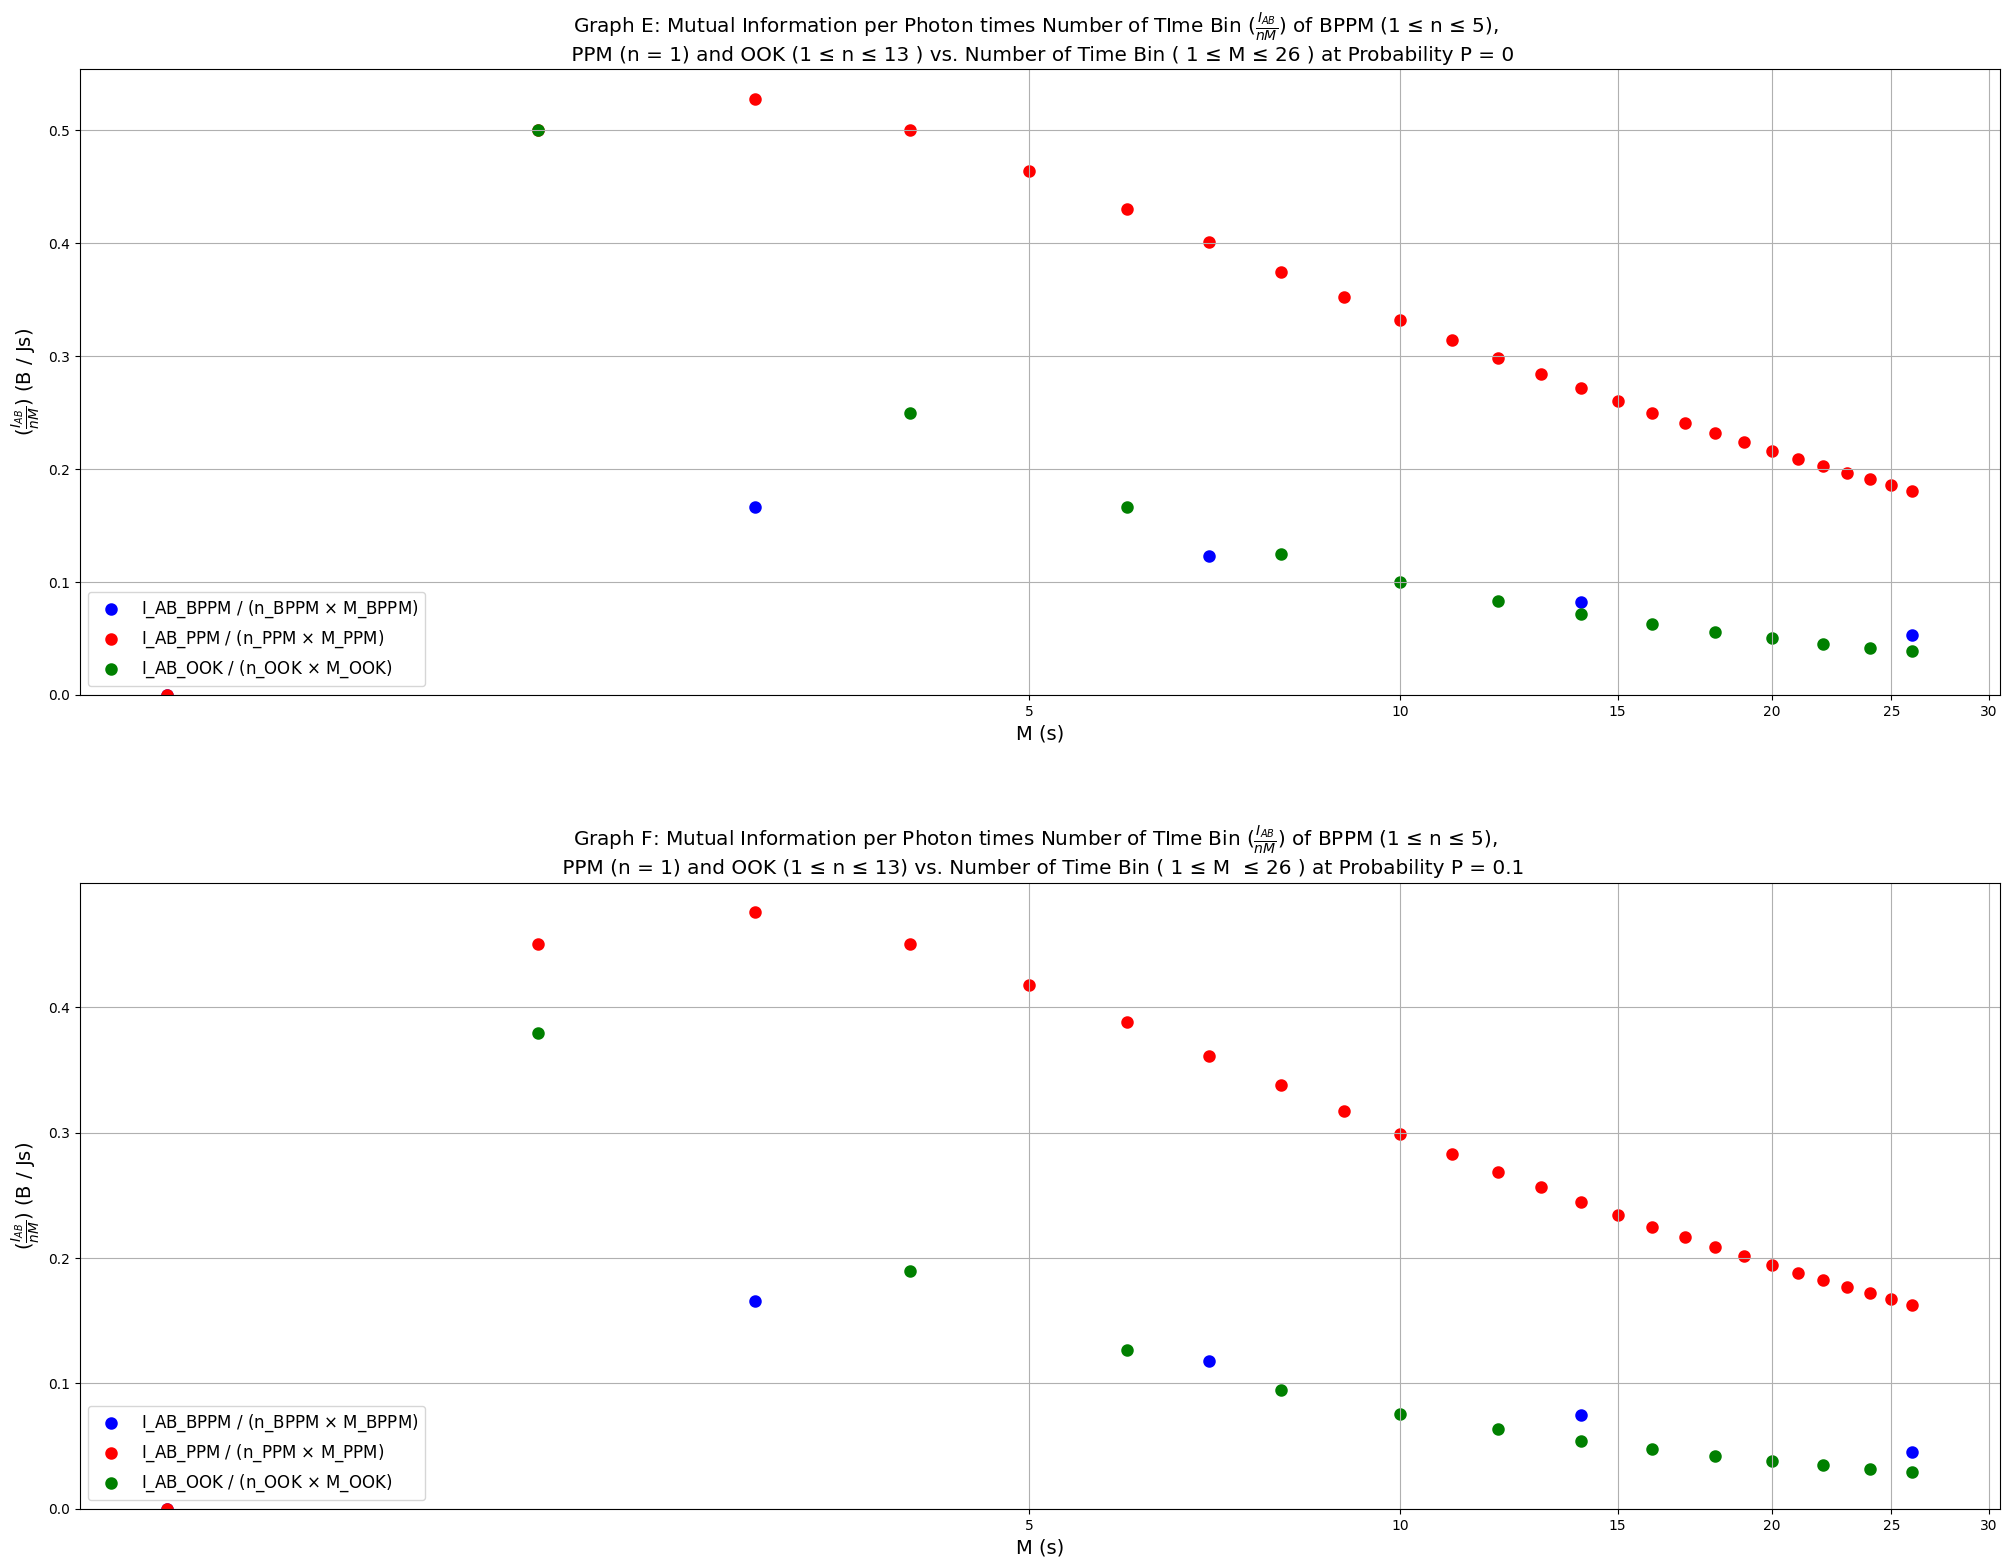

In [ ]:
figure, (ax1, ax2) = plt.subplots(2,1,figsize=(24,18))

ax1.scatter(TimeBin_BPPM_list_0, IperPhotonTimeBin_AB_BPPM_list_0, label='I_AB_BPPM / (n_BPPM $\\times$ M_BPPM)', color ='blue', linewidth=3, alpha=1)
ax1.scatter(TimeBin_PPM_list_0, IperPhotonTimeBin_AB_PPM_list_0, label='I_AB_PPM / (n_PPM $\\times$ M_PPM)', color ='red', linewidth=3, alpha=1)
ax1.scatter(TimeBin_OOK_list_0, IperPhotonTimeBin_AB_OOK_list_0, label='I_AB_OOK / (n_OOK $\\times$ M_OOK)', color ='green', linewidth=3, alpha=1)

ax1.set_xscale('log', base = 2)
ax1.xaxis.set_major_formatter(formatter)
# Set the tick locators and formatters for the x-axis
ax1.xaxis.set_major_locator(AutoLocator())
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.xaxis.set_tick_params(which='both', labelsize=10)

ax1.set_title('Graph E: Mutual Information per Photon times Number of TIme Bin ($\\frac{I_{AB}}{n M}$) of BPPM (1 \u2264 n \u2264 5),  \n PPM (n = 1) and OOK (1 \u2264 n \u2264 13 ) vs. Number of Time Bin ( 1 \u2264 M \u2264 26 ) at Probability P = 0', fontsize='x-large')
ax1.set_xlabel('M (s)', fontsize = 14)
ax1.set_ylabel('($\\frac{I_{AB}}{n M}$) (B / Js)', fontsize = 14)
ax1.set_ylim(0)
ax1.grid(True)
ax1.legend(loc = 'lower left', fontsize=12)

ax2.scatter(TimeBin_BPPM_list_0_1, IperPhotonTimeBin_AB_BPPM_list_0_1, label='I_AB_BPPM / (n_BPPM $\\times$ M_BPPM)', color ='blue', linewidth=3, alpha=1)
ax2.scatter(TimeBin_PPM_list_0_1, IperPhotonTimeBin_AB_PPM_list_0_1, label='I_AB_PPM / (n_PPM $\\times$ M_PPM)', color ='red', linewidth=3, alpha=1)
ax2.scatter(TimeBin_OOK_list_0_1, IperPhotonTimeBin_AB_OOK_list_0_1, label='I_AB_OOK / (n_OOK $\\times$ M_OOK)', color ='green', linewidth=3, alpha=1)

ax2.set_xscale('log', base = 2)
ax2.xaxis.set_major_formatter(formatter)
# Set the tick locators and formatters for the x-axis
ax2.xaxis.set_major_locator(AutoLocator())
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.xaxis.set_tick_params(which='both', labelsize=10)

ax2.set_title('Graph F: Mutual Information per Photon times Number of TIme Bin ($\\frac{I_{AB}}{n M}$) of BPPM (1 \u2264 n \u2264 5),  \n PPM (n = 1) and OOK (1 \u2264 n \u2264 13) vs. Number of Time Bin ( 1 \u2264 M  \u2264 26 ) at Probability P = 0.1', fontsize='x-large')
ax2.set_xlabel('M (s)', fontsize = 14)
ax2.set_ylabel('($\\frac{I_{AB}}{n M}$) (B / Js)', fontsize = 14)
ax2.set_ylim(0)
ax2.grid(True)
ax2.legend(loc = 'lower left', fontsize=12)

figure.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.3, hspace=0.3)
figure.set_facecolor("white")
plt.savefig('protocol/3NewMetricsLog.png', dpi=450, bbox_inches='tight')
plt.show()